#Install Depedencies

In [ ]:
!pip install optuna pytorch-tabnet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from pytorch_tabnet.tab_model import TabNetClassifier
from imblearn.over_sampling import SMOTE

#Create Dataframe

In [ ]:
df = pd.read_csv('put dataset directory here')

#Preprocessing

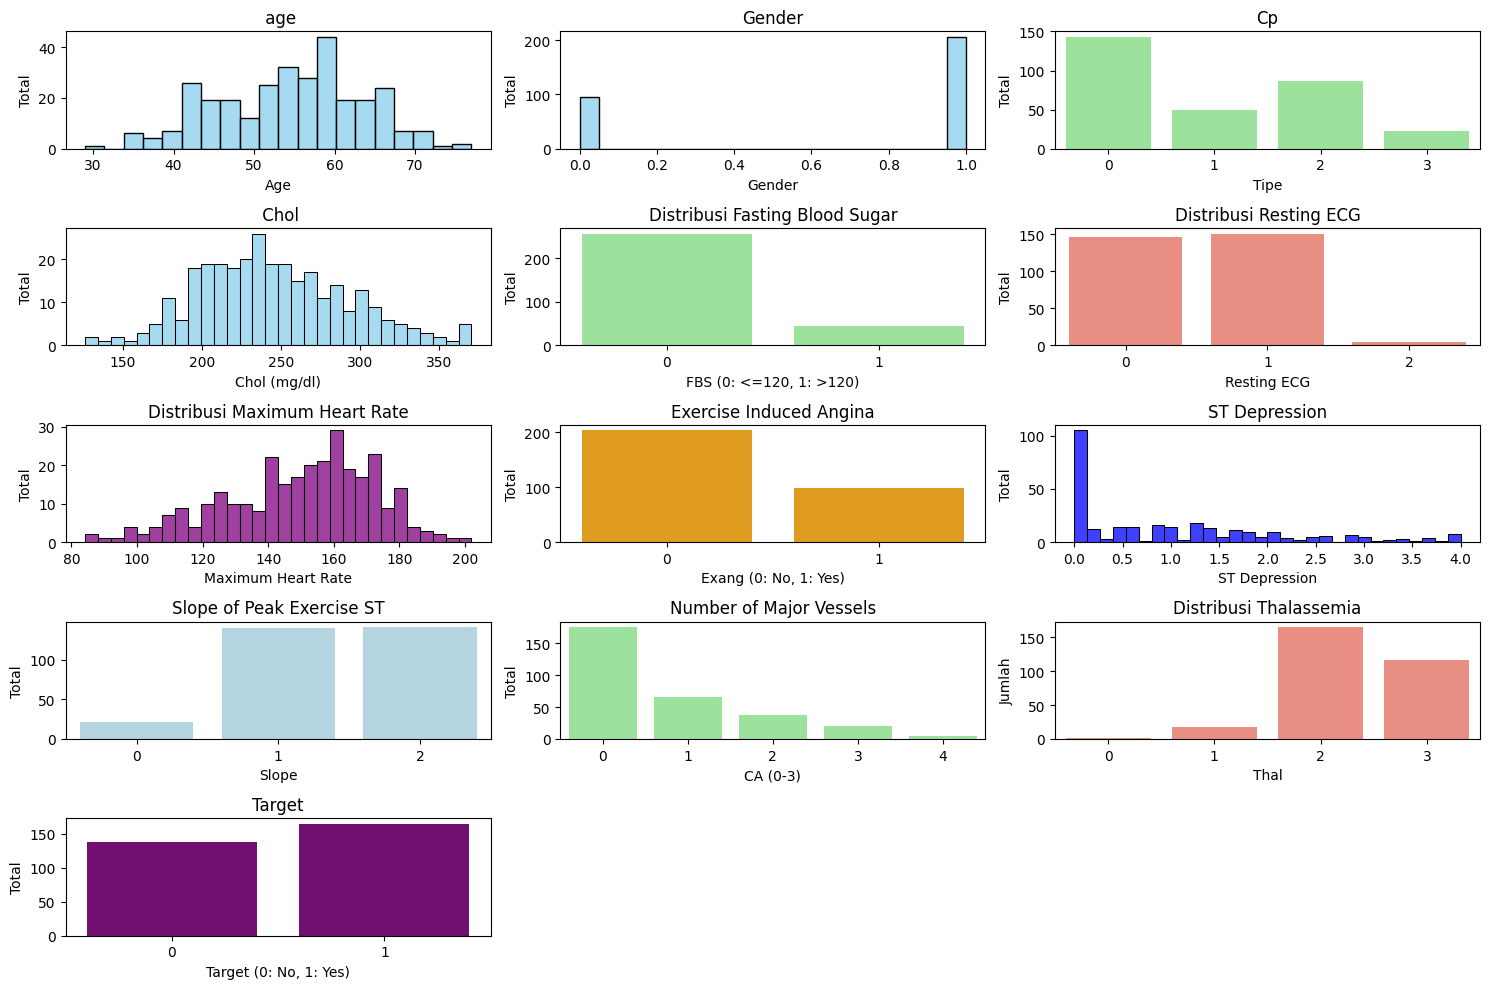

In [ ]:
# show feature distribution
plt.figure(figsize=(15, 10))

plt.subplot(5, 3, 1)
sns.histplot(data=df, x='age', bins=20, color='skyblue')
plt.title(' age')
plt.xlabel('Age')
plt.ylabel('Total')

plt.subplot(5, 3, 2)
sns.histplot(data=df, x='sex', bins=20, color='skyblue')
plt.title('Gender')
plt.xlabel('Gender')
plt.ylabel('Total')


plt.subplot(5, 3, 3)
sns.countplot(data=df, x='cp', color='lightgreen')
plt.title('Cp')
plt.xlabel('Tipe')
plt.ylabel('Total')

plt.subplot(5, 3, 4)
sns.histplot(data=df, x='chol', bins=30, color='skyblue')
plt.title(' Chol')
plt.xlabel('Chol (mg/dl)')
plt.ylabel('Total')

plt.subplot(5, 3, 5)
sns.countplot(data=df, x='fbs', color='lightgreen')
plt.title('Distribusi Fasting Blood Sugar')
plt.xlabel('FBS (0: <=120, 1: >120)')
plt.ylabel('Total')

plt.subplot(5, 3, 6)
sns.countplot(data=df, x='restecg', color='salmon')
plt.title('Distribusi Resting ECG')
plt.xlabel('Resting ECG')
plt.ylabel('Total')

plt.subplot(5, 3, 7)
sns.histplot(data=df, x='thalach', bins=30, color='purple')
plt.title('Distribusi Maximum Heart Rate')
plt.xlabel('Maximum Heart Rate')
plt.ylabel('Total')

plt.subplot(5, 3, 8)
sns.countplot(data=df, x='exang', color='orange')
plt.title('Exercise Induced Angina')
plt.xlabel('Exang (0: No, 1: Yes)')
plt.ylabel('Total')

plt.subplot(5, 3, 9)
sns.histplot(data=df, x='oldpeak', bins=30, color='blue')
plt.title('ST Depression')
plt.xlabel('ST Depression')
plt.ylabel('Total')

plt.subplot(5, 3, 10)
sns.countplot(data=df, x='slope', color='lightblue')
plt.title('Slope of Peak Exercise ST')
plt.xlabel('Slope')
plt.ylabel('Total')

plt.subplot(5, 3, 11)
sns.countplot(data=df, x='ca', color='lightgreen')
plt.title('Number of Major Vessels')
plt.xlabel('CA (0-3)')
plt.ylabel('Total')

plt.subplot(5, 3, 12)
sns.countplot(data=df, x='thal', color='salmon')
plt.title('Distribusi Thalassemia')
plt.xlabel('Thal')
plt.ylabel('Jumlah')

plt.subplot(5, 3, 13)
sns.countplot(data=df, x='target', color='purple')
plt.title('Target')
plt.xlabel('Target (0: No, 1: Yes)')
plt.ylabel('Total')

plt.savefig('visualisasi_data.png', dpi=300, bbox_inches='tight')
plt.tight_layout(h_pad=1, w_pad=1)
plt.show()

missing values

In [ ]:
print(df.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


duplicate data

In [ ]:
print(df.duplicated().sum())
df = df.drop_duplicates()

1


outliers on continues feature

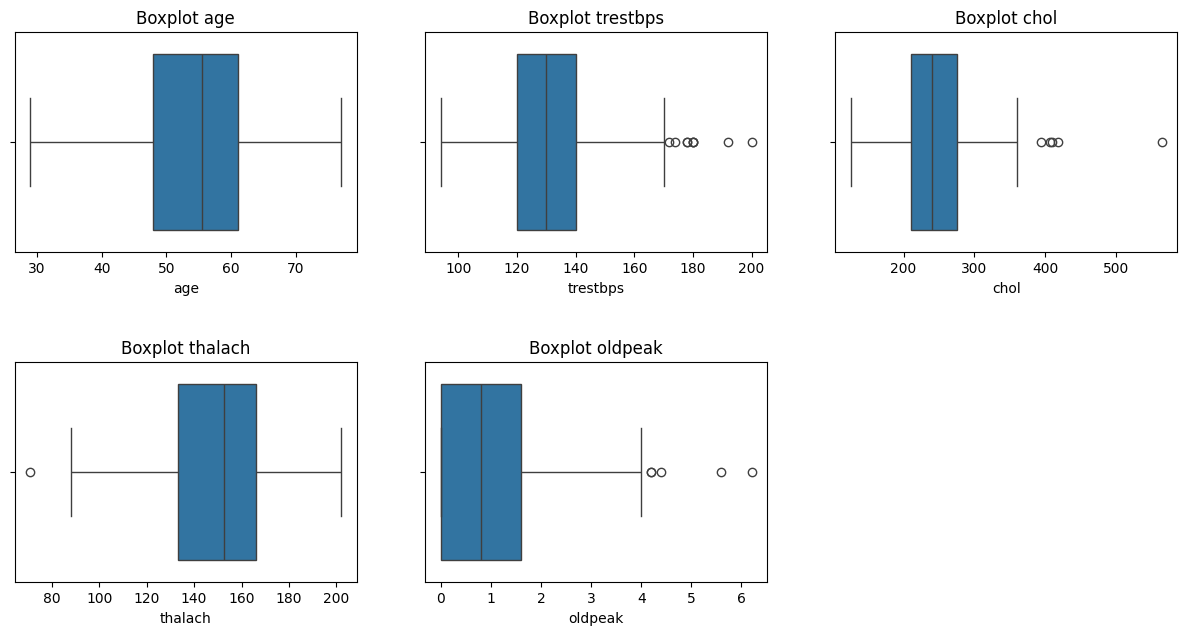

In [ ]:
num_cols = 14
rows = (num_cols // 3) + (num_cols % 3 > 0)
fig, axes = plt.subplots(rows, 3, figsize=(15, 4 * rows))
fig.subplots_adjust(hspace=0.5)

columns = ['age', 'trestbps', 'chol', 'thalach','oldpeak']

for i, col in enumerate(columns):
    ax = axes[i // 3, i % 3]
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'Boxplot {col}')

for j in range(len(columns), rows * 3):
    fig.delaxes(axes.flatten()[j])

plt.show()

function to handle outliers

In [ ]:
def replace_outliers(df, column):
    # count Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Determine the lower and upper limits for outliers.
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with lower or upper bound values.
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    return df

# Call the function for each column that needs to be changed.
columns = ['trestbps', 'chol', 'thalach', 'oldpeak']
for col in columns:
    df = replace_outliers(df, col)

print(df[columns].head())

   trestbps   chol  thalach  oldpeak
0     145.0  233.0    150.0      2.3
1     130.0  250.0    187.0      3.5
2     130.0  204.0    172.0      1.4
3     120.0  236.0    178.0      0.8
4     120.0  354.0    163.0      0.6


Visualization of outlier replacement

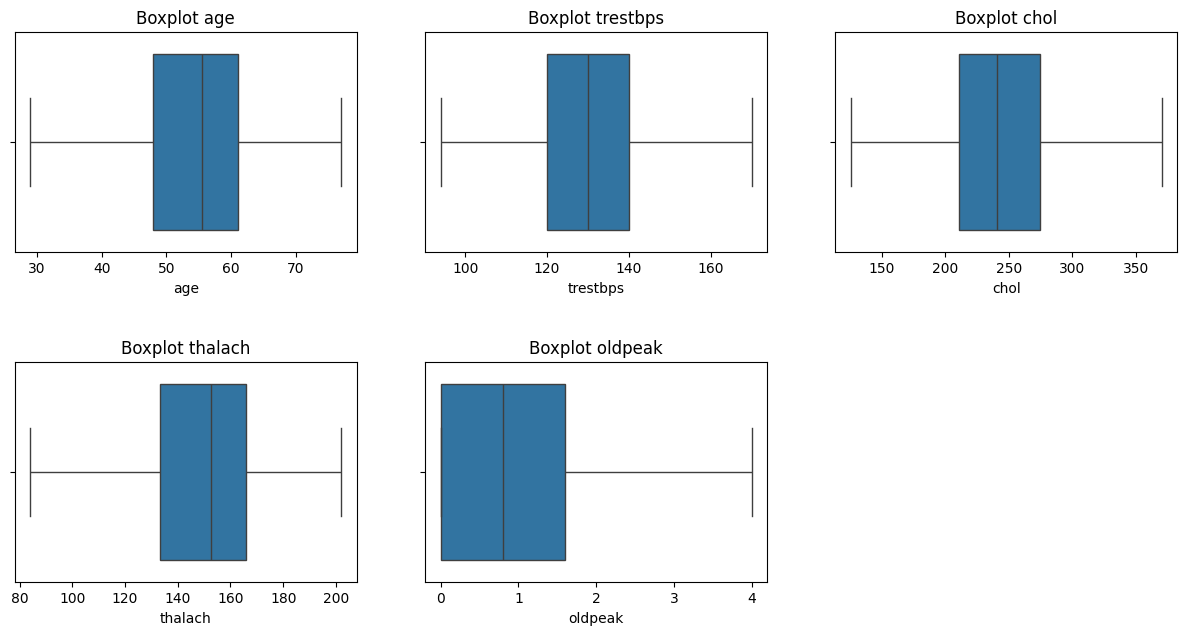

In [ ]:
num_cols = 14
rows = (num_cols // 3) + (num_cols % 3 > 0)
fig, axes = plt.subplots(rows, 3, figsize=(15, 4 * rows))
fig.subplots_adjust(hspace=0.5)

columns = ['age', 'trestbps', 'chol', 'thalach','oldpeak']

for i, col in enumerate(columns):
    ax = axes[i // 3, i % 3]
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'Boxplot {col}')

for j in range(len(columns), rows * 3):
    fig.delaxes(axes.flatten()[j])

plt.show()


descriptive statistics of data after preprocessing

In [ ]:
description = df.describe().T
description['Skew'] = df.skew()
description['Kurt'] = df.kurt()
description['STD'] = df.std()

print(description[['mean', 'min', 'max', 'Skew', 'Kurt', 'std']])

                mean      min      max      Skew      Kurt        std
age        54.420530   29.000   77.000 -0.203743 -0.527512   9.047970
sex         0.682119    0.000    1.000 -0.786120 -1.391273   0.466426
cp          0.963576    0.000    3.000  0.493022 -1.183729   1.032044
trestbps  131.258278   94.000  170.000  0.389876 -0.158677  16.605232
chol      245.377070  126.000  370.375  0.335700 -0.091647  47.486683
fbs         0.149007    0.000    1.000  1.981201  1.937947   0.356686
restecg     0.526490    0.000    2.000  0.169467 -1.359464   0.526027
thalach   149.612997   84.125  202.000 -0.490122 -0.235395  22.765983
exang       0.327815    0.000    1.000  0.737281 -1.466170   0.470196
oldpeak     1.027815    0.000    4.000  0.993897  0.115932   1.110395
slope       1.397351    0.000    2.000 -0.503247 -0.629935   0.616274
ca          0.718543    0.000    4.000  1.295738  0.781003   1.006748
thal        2.314570    0.000    3.000 -0.481232  0.295855   0.613026
target      0.543046

In [ ]:
dataset1 = df.copy()
dataset2 = df.copy()

#Experiment 1

data train and test

In [ ]:
X = dataset1.drop('target', axis=1)
y = dataset1['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

define model

In [ ]:
model1 = TabNetClassifier()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
#train model
model1.fit(
    X_train.values, y_train,
    eval_metric=['logloss'],
    batch_size=32,
    virtual_batch_size=32,
    patience=20,
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.85219 |  0:00:00s
epoch 1  | loss: 0.64056 |  0:00:00s
epoch 2  | loss: 0.59696 |  0:00:00s
epoch 3  | loss: 0.59483 |  0:00:00s
epoch 4  | loss: 0.56147 |  0:00:00s
epoch 5  | loss: 0.50008 |  0:00:01s
epoch 6  | loss: 0.5211  |  0:00:01s
epoch 7  | loss: 0.42613 |  0:00:01s
epoch 8  | loss: 0.50036 |  0:00:01s
epoch 9  | loss: 0.47256 |  0:00:01s
epoch 10 | loss: 0.48413 |  0:00:01s
epoch 11 | loss: 0.49059 |  0:00:01s
epoch 12 | loss: 0.45287 |  0:00:02s
epoch 13 | loss: 0.44093 |  0:00:02s
epoch 14 | loss: 0.44996 |  0:00:02s
epoch 15 | loss: 0.42231 |  0:00:02s
epoch 16 | loss: 0.46133 |  0:00:02s
epoch 17 | loss: 0.33283 |  0:00:02s
epoch 18 | loss: 0.38121 |  0:00:02s
epoch 19 | loss: 0.39487 |  0:00:03s
epoch 20 | loss: 0.36743 |  0:00:03s
epoch 21 | loss: 0.3632  |  0:00:03s
epoch 22 | loss: 0.34315 |  0:00:03s
epoch 23 | loss: 0.31929 |  0:00:03s
epoch 24 | loss: 0.34199 |  0:00:04s
epoch 25 | loss: 0.34831 |  0:00:04s
epoch 26 | loss: 0.33384 |  0:00:04s
e

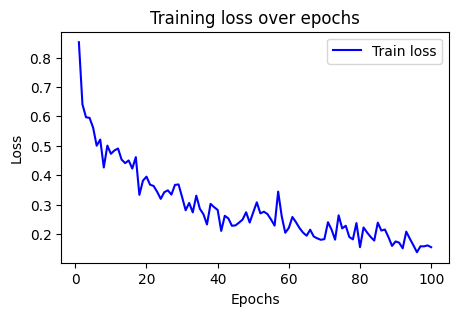

In [ ]:
loss_values = model1.history['loss']

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(loss_values) + 1), loss_values, 'b', label='Train loss')
plt.title('Training loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluation

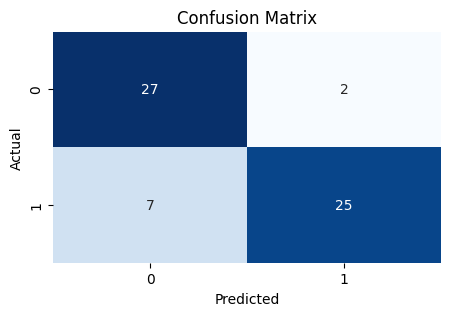

Accuracy : 0.8524590163934426
Precision: 0.9259259259259259
Recall   : 0.78125
F1 Score : 0.847457627118644


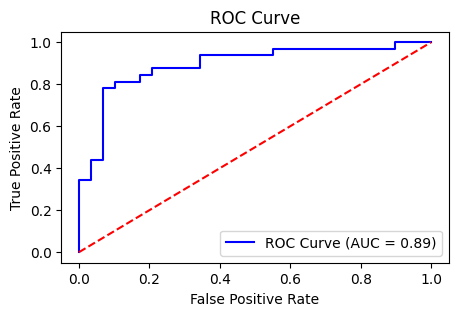

In [ ]:
# Confussion matrix and AUC-ROC

y_pred = model1.predict(X_test.values)
y_pred_proba = model1.predict_proba(X_test.values)[:, 1]

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Implementation Optimization with optuna

In [ ]:
def objective(trial):
    # define parameters
    n_d = trial.suggest_int('n_d', 8, 32)
    n_a = trial.suggest_int('n_a', 8, 32)
    n_steps = trial.suggest_int('n_steps', 5, 8)
    n_independent = trial.suggest_int('n_independent', 1, 2)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_float('lambda_sparse', 1e-4, 1e-2)
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True)

    # define model with parameters
    model1_optimasi = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        n_independent=n_independent,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_params=dict(lr=learning_rate)
    )

    # train model
    model1_optimasi.fit(
        X_train.values, y_train,
        max_epochs=100,
        batch_size=32,
        virtual_batch_size=32,
        patience=20
    )

    # Evaluation
    preds =  model1_optimasi.predict(X_test.values)
    accuracy = accuracy_score(y_test, preds)

    return accuracy

# setting optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# best result from optimization
print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-12-18 02:22:17,269] A new study created in memory with name: no-name-5fb7483b-a8fa-46f9-bf8b-78741ff92a1e
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.82597 |  0:00:00s
epoch 1  | loss: 0.69463 |  0:00:01s
epoch 2  | loss: 0.53071 |  0:00:02s
epoch 3  | loss: 0.65453 |  0:00:03s
epoch 4  | loss: 0.62662 |  0:00:04s
epoch 5  | loss: 0.54807 |  0:00:05s
epoch 6  | loss: 0.52726 |  0:00:06s
epoch 7  | loss: 0.5389  |  0:00:06s
epoch 8  | loss: 0.46412 |  0:00:07s
epoch 9  | loss: 0.52873 |  0:00:07s
epoch 10 | loss: 0.53384 |  0:00:08s
epoch 11 | loss: 0.4877  |  0:00:08s
epoch 12 | loss: 0.56442 |  0:00:08s
epoch 13 | loss: 0.45528 |  0:00:09s
epoch 14 | loss: 0.44627 |  0:00:09s
epoch 15 | loss: 0.46445 |  0:00:09s
epoch 16 | loss: 0.42488 |  0:00:09s
epoch 17 | loss: 0.40373 |  0:00:10s
epoch 18 | loss: 0.39927 |  0:00:10s
epoch 19 | loss: 0.44859 |  0:00:10s
epoch 20 | loss: 0.38249 |  0:00:10s
epoch 21 | loss: 0.35113 |  0:00:10s
epoch 22 | loss: 0.33153 |  0:00:11s
epoch 23 | loss: 0.40277 |  0:00:11s
epoch 24 | loss: 0.36127 |  0:00:11s
epoch 25 | loss: 0.41597 |  0:00:11s
epoch 26 | loss: 0.36316 |  0:00:12s
e

[I 2024-12-18 02:22:59,892] Trial 0 finished with value: 0.8032786885245902 and parameters: {'n_d': 26, 'n_a': 10, 'n_steps': 5, 'n_independent': 2, 'gamma': 1.461891101847133, 'lambda_sparse': 0.00015059319835416342, 'learning_rate': 0.021636880753304357}. Best is trial 0 with value: 0.8032786885245902.


epoch 99 | loss: 0.15546 |  0:00:42s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.31636 |  0:00:00s
epoch 1  | loss: 0.80892 |  0:00:00s
epoch 2  | loss: 0.55298 |  0:00:00s
epoch 3  | loss: 0.59438 |  0:00:01s
epoch 4  | loss: 0.49894 |  0:00:01s
epoch 5  | loss: 0.70906 |  0:00:01s
epoch 6  | loss: 0.60154 |  0:00:02s
epoch 7  | loss: 0.56383 |  0:00:02s
epoch 8  | loss: 0.4637  |  0:00:02s
epoch 9  | loss: 0.45684 |  0:00:02s
epoch 10 | loss: 0.52237 |  0:00:03s
epoch 11 | loss: 0.5686  |  0:00:03s
epoch 12 | loss: 0.54621 |  0:00:03s
epoch 13 | loss: 0.50777 |  0:00:04s
epoch 14 | loss: 0.48925 |  0:00:04s
epoch 15 | loss: 0.42235 |  0:00:04s
epoch 16 | loss: 0.46235 |  0:00:05s
epoch 17 | loss: 0.47923 |  0:00:05s
epoch 18 | loss: 0.45411 |  0:00:05s
epoch 19 | loss: 0.47207 |  0:00:06s
epoch 20 | loss: 0.44516 |  0:00:06s
epoch 21 | loss: 0.40463 |  0:00:06s
epoch 22 | loss: 0.42742 |  0:00:06s
epoch 23 | loss: 0.42576 |  0:00:07s
epoch 24 | loss: 0.3789  |  0:00:07s
epoch 25 | loss: 0.38808 |  0:00:07s
epoch 26 | loss: 0.40889 |  0:00:08s
e

[I 2024-12-18 02:23:32,436] Trial 1 finished with value: 0.8688524590163934 and parameters: {'n_d': 15, 'n_a': 13, 'n_steps': 7, 'n_independent': 2, 'gamma': 1.859907843673646, 'lambda_sparse': 0.0021592260898675012, 'learning_rate': 0.02048054225166199}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.27014 |  0:00:32s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.76141 |  0:00:00s
epoch 1  | loss: 0.61556 |  0:00:00s
epoch 2  | loss: 0.57576 |  0:00:00s
epoch 3  | loss: 0.6672  |  0:00:00s
epoch 4  | loss: 0.55039 |  0:00:00s
epoch 5  | loss: 0.4999  |  0:00:01s
epoch 6  | loss: 0.47843 |  0:00:01s
epoch 7  | loss: 0.48704 |  0:00:01s
epoch 8  | loss: 0.51568 |  0:00:01s
epoch 9  | loss: 0.4187  |  0:00:01s
epoch 10 | loss: 0.42768 |  0:00:02s
epoch 11 | loss: 0.4556  |  0:00:02s
epoch 12 | loss: 0.46548 |  0:00:02s
epoch 13 | loss: 0.37121 |  0:00:02s
epoch 14 | loss: 0.33916 |  0:00:02s
epoch 15 | loss: 0.36533 |  0:00:03s
epoch 16 | loss: 0.42377 |  0:00:03s
epoch 17 | loss: 0.37928 |  0:00:03s
epoch 18 | loss: 0.40594 |  0:00:03s
epoch 19 | loss: 0.39637 |  0:00:03s
epoch 20 | loss: 0.42068 |  0:00:03s
epoch 21 | loss: 0.36735 |  0:00:04s
epoch 22 | loss: 0.38973 |  0:00:04s
epoch 23 | loss: 0.35903 |  0:00:04s
epoch 24 | loss: 0.38271 |  0:00:04s
epoch 25 | loss: 0.34993 |  0:00:04s
epoch 26 | loss: 0.33815 |  0:00:05s
e

[I 2024-12-18 02:23:53,039] Trial 2 finished with value: 0.7868852459016393 and parameters: {'n_d': 9, 'n_a': 18, 'n_steps': 5, 'n_independent': 1, 'gamma': 1.2819066887019752, 'lambda_sparse': 0.0014060967988335292, 'learning_rate': 0.07739427192002946}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.182   |  0:00:20s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.60732 |  0:00:00s
epoch 1  | loss: 1.16546 |  0:00:00s
epoch 2  | loss: 0.85256 |  0:00:01s
epoch 3  | loss: 0.79015 |  0:00:01s
epoch 4  | loss: 0.57381 |  0:00:01s
epoch 5  | loss: 0.6482  |  0:00:02s
epoch 6  | loss: 0.86182 |  0:00:02s
epoch 7  | loss: 0.53576 |  0:00:02s
epoch 8  | loss: 0.67281 |  0:00:03s
epoch 9  | loss: 0.58906 |  0:00:03s
epoch 10 | loss: 0.6155  |  0:00:04s
epoch 11 | loss: 0.69096 |  0:00:04s
epoch 12 | loss: 0.57292 |  0:00:04s
epoch 13 | loss: 0.5607  |  0:00:04s
epoch 14 | loss: 0.57732 |  0:00:05s
epoch 15 | loss: 0.59926 |  0:00:05s
epoch 16 | loss: 0.60442 |  0:00:05s
epoch 17 | loss: 0.55389 |  0:00:05s
epoch 18 | loss: 0.52725 |  0:00:06s
epoch 19 | loss: 0.52716 |  0:00:06s
epoch 20 | loss: 0.46169 |  0:00:06s
epoch 21 | loss: 0.43248 |  0:00:06s
epoch 22 | loss: 0.47243 |  0:00:07s
epoch 23 | loss: 0.48561 |  0:00:07s
epoch 24 | loss: 0.50399 |  0:00:07s
epoch 25 | loss: 0.43441 |  0:00:07s
epoch 26 | loss: 0.44613 |  0:00:08s
e

[I 2024-12-18 02:24:22,323] Trial 3 finished with value: 0.7377049180327869 and parameters: {'n_d': 31, 'n_a': 14, 'n_steps': 7, 'n_independent': 1, 'gamma': 1.8001537103887604, 'lambda_sparse': 0.004776713603990065, 'learning_rate': 0.014817217240575439}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.21001 |  0:00:29s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.06914 |  0:00:00s
epoch 1  | loss: 0.76621 |  0:00:00s
epoch 2  | loss: 0.69899 |  0:00:00s
epoch 3  | loss: 0.503   |  0:00:01s
epoch 4  | loss: 0.40358 |  0:00:01s
epoch 5  | loss: 0.44467 |  0:00:01s
epoch 6  | loss: 0.38132 |  0:00:02s
epoch 7  | loss: 0.54016 |  0:00:02s
epoch 8  | loss: 0.49984 |  0:00:02s
epoch 9  | loss: 0.41778 |  0:00:03s
epoch 10 | loss: 0.36245 |  0:00:03s
epoch 11 | loss: 0.35735 |  0:00:03s
epoch 12 | loss: 0.37982 |  0:00:04s
epoch 13 | loss: 0.4327  |  0:00:04s
epoch 14 | loss: 0.39222 |  0:00:04s
epoch 15 | loss: 0.3724  |  0:00:05s
epoch 16 | loss: 0.36233 |  0:00:05s
epoch 17 | loss: 0.41781 |  0:00:05s
epoch 18 | loss: 0.2836  |  0:00:05s
epoch 19 | loss: 0.33695 |  0:00:06s
epoch 20 | loss: 0.37437 |  0:00:06s
epoch 21 | loss: 0.41145 |  0:00:06s
epoch 22 | loss: 0.34534 |  0:00:06s
epoch 23 | loss: 0.33258 |  0:00:07s
epoch 24 | loss: 0.30512 |  0:00:07s
epoch 25 | loss: 0.34004 |  0:00:07s
epoch 26 | loss: 0.32749 |  0:00:07s
e

[I 2024-12-18 02:24:48,616] Trial 4 finished with value: 0.819672131147541 and parameters: {'n_d': 32, 'n_a': 29, 'n_steps': 6, 'n_independent': 1, 'gamma': 1.0482396192535344, 'lambda_sparse': 0.0020532263634371922, 'learning_rate': 0.013385992783305383}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.21992 |  0:00:26s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.23619 |  0:00:00s
epoch 1  | loss: 0.977   |  0:00:00s
epoch 2  | loss: 0.6702  |  0:00:00s
epoch 3  | loss: 0.84032 |  0:00:01s
epoch 4  | loss: 0.61725 |  0:00:01s
epoch 5  | loss: 0.5414  |  0:00:01s
epoch 6  | loss: 0.78592 |  0:00:02s
epoch 7  | loss: 0.50024 |  0:00:02s
epoch 8  | loss: 0.72474 |  0:00:02s
epoch 9  | loss: 0.55182 |  0:00:02s
epoch 10 | loss: 0.57031 |  0:00:03s
epoch 11 | loss: 0.48928 |  0:00:03s
epoch 12 | loss: 0.53809 |  0:00:03s
epoch 13 | loss: 0.53045 |  0:00:04s
epoch 14 | loss: 0.51442 |  0:00:04s
epoch 15 | loss: 0.47475 |  0:00:04s
epoch 16 | loss: 0.53986 |  0:00:05s
epoch 17 | loss: 0.49442 |  0:00:05s
epoch 18 | loss: 0.50769 |  0:00:06s
epoch 19 | loss: 0.49928 |  0:00:06s
epoch 20 | loss: 0.44985 |  0:00:07s
epoch 21 | loss: 0.48943 |  0:00:07s
epoch 22 | loss: 0.47353 |  0:00:07s
epoch 23 | loss: 0.40796 |  0:00:08s
epoch 24 | loss: 0.42859 |  0:00:08s
epoch 25 | loss: 0.46984 |  0:00:09s
epoch 26 | loss: 0.45501 |  0:00:09s
e

[I 2024-12-18 02:25:21,365] Trial 5 finished with value: 0.8524590163934426 and parameters: {'n_d': 13, 'n_a': 23, 'n_steps': 7, 'n_independent': 2, 'gamma': 1.9486433991610315, 'lambda_sparse': 0.004237849488815964, 'learning_rate': 0.01489324593755659}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.24455 |  0:00:32s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.22436 |  0:00:00s
epoch 1  | loss: 0.71605 |  0:00:00s
epoch 2  | loss: 0.60381 |  0:00:00s
epoch 3  | loss: 0.62237 |  0:00:01s
epoch 4  | loss: 0.54142 |  0:00:01s
epoch 5  | loss: 0.49454 |  0:00:01s
epoch 6  | loss: 0.53506 |  0:00:02s
epoch 7  | loss: 0.54509 |  0:00:02s
epoch 8  | loss: 0.55943 |  0:00:02s
epoch 9  | loss: 0.54516 |  0:00:03s
epoch 10 | loss: 0.55966 |  0:00:03s
epoch 11 | loss: 0.45064 |  0:00:03s
epoch 12 | loss: 0.54861 |  0:00:04s
epoch 13 | loss: 0.46372 |  0:00:04s
epoch 14 | loss: 0.42793 |  0:00:05s
epoch 15 | loss: 0.45328 |  0:00:05s
epoch 16 | loss: 0.42351 |  0:00:05s
epoch 17 | loss: 0.45687 |  0:00:06s
epoch 18 | loss: 0.44405 |  0:00:06s
epoch 19 | loss: 0.42968 |  0:00:06s
epoch 20 | loss: 0.45307 |  0:00:06s
epoch 21 | loss: 0.41139 |  0:00:07s
epoch 22 | loss: 0.39898 |  0:00:07s
epoch 23 | loss: 0.40008 |  0:00:07s
epoch 24 | loss: 0.40942 |  0:00:07s
epoch 25 | loss: 0.35808 |  0:00:08s
epoch 26 | loss: 0.42633 |  0:00:08s
e

[I 2024-12-18 02:25:50,044] Trial 6 finished with value: 0.8524590163934426 and parameters: {'n_d': 12, 'n_a': 12, 'n_steps': 6, 'n_independent': 2, 'gamma': 1.4460892072118663, 'lambda_sparse': 0.007282000459152636, 'learning_rate': 0.029374062533672335}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.30796 |  0:00:28s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.37586 |  0:00:00s
epoch 1  | loss: 0.86989 |  0:00:00s
epoch 2  | loss: 0.57745 |  0:00:00s
epoch 3  | loss: 0.67584 |  0:00:01s
epoch 4  | loss: 0.61067 |  0:00:01s
epoch 5  | loss: 0.54761 |  0:00:01s
epoch 6  | loss: 0.58322 |  0:00:02s
epoch 7  | loss: 0.51857 |  0:00:02s
epoch 8  | loss: 0.48699 |  0:00:02s
epoch 9  | loss: 0.44976 |  0:00:03s
epoch 10 | loss: 0.54564 |  0:00:03s
epoch 11 | loss: 0.48161 |  0:00:03s
epoch 12 | loss: 0.46898 |  0:00:03s
epoch 13 | loss: 0.50146 |  0:00:04s
epoch 14 | loss: 0.47943 |  0:00:04s
epoch 15 | loss: 0.46692 |  0:00:04s
epoch 16 | loss: 0.4547  |  0:00:05s
epoch 17 | loss: 0.44131 |  0:00:05s
epoch 18 | loss: 0.46781 |  0:00:05s
epoch 19 | loss: 0.5101  |  0:00:06s
epoch 20 | loss: 0.47265 |  0:00:06s
epoch 21 | loss: 0.42327 |  0:00:06s
epoch 22 | loss: 0.38302 |  0:00:07s
epoch 23 | loss: 0.41352 |  0:00:07s
epoch 24 | loss: 0.48177 |  0:00:07s
epoch 25 | loss: 0.46521 |  0:00:08s
epoch 26 | loss: 0.46618 |  0:00:08s
e

[I 2024-12-18 02:26:17,603] Trial 7 finished with value: 0.7868852459016393 and parameters: {'n_d': 13, 'n_a': 9, 'n_steps': 6, 'n_independent': 1, 'gamma': 1.6454117937665893, 'lambda_sparse': 0.009781196748296118, 'learning_rate': 0.09952069532604448}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.31908 |  0:00:27s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.93019 |  0:00:00s
epoch 1  | loss: 0.60176 |  0:00:00s
epoch 2  | loss: 0.52053 |  0:00:00s
epoch 3  | loss: 0.51508 |  0:00:00s
epoch 4  | loss: 0.64454 |  0:00:01s
epoch 5  | loss: 0.52276 |  0:00:01s
epoch 6  | loss: 0.5499  |  0:00:01s
epoch 7  | loss: 0.53867 |  0:00:01s
epoch 8  | loss: 0.50384 |  0:00:02s
epoch 9  | loss: 0.55125 |  0:00:02s
epoch 10 | loss: 0.48079 |  0:00:02s
epoch 11 | loss: 0.58614 |  0:00:02s
epoch 12 | loss: 0.4384  |  0:00:02s
epoch 13 | loss: 0.60407 |  0:00:03s
epoch 14 | loss: 0.47208 |  0:00:03s
epoch 15 | loss: 0.49291 |  0:00:03s
epoch 16 | loss: 0.50652 |  0:00:03s
epoch 17 | loss: 0.47706 |  0:00:04s
epoch 18 | loss: 0.44955 |  0:00:04s
epoch 19 | loss: 0.34566 |  0:00:04s
epoch 20 | loss: 0.33649 |  0:00:04s
epoch 21 | loss: 0.31754 |  0:00:05s
epoch 22 | loss: 0.34108 |  0:00:05s
epoch 23 | loss: 0.32779 |  0:00:05s
epoch 24 | loss: 0.33601 |  0:00:06s
epoch 25 | loss: 0.36165 |  0:00:06s
epoch 26 | loss: 0.39239 |  0:00:06s
e

[I 2024-12-18 02:26:42,932] Trial 8 finished with value: 0.7540983606557377 and parameters: {'n_d': 20, 'n_a': 16, 'n_steps': 6, 'n_independent': 1, 'gamma': 1.4387845104083605, 'lambda_sparse': 0.006318214539095838, 'learning_rate': 0.028190321897314363}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.24001 |  0:00:25s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.18509 |  0:00:00s
epoch 1  | loss: 0.9575  |  0:00:00s
epoch 2  | loss: 0.72601 |  0:00:00s
epoch 3  | loss: 0.6232  |  0:00:01s
epoch 4  | loss: 0.53454 |  0:00:01s
epoch 5  | loss: 0.58758 |  0:00:01s
epoch 6  | loss: 0.53245 |  0:00:02s
epoch 7  | loss: 0.56488 |  0:00:02s
epoch 8  | loss: 0.49379 |  0:00:02s
epoch 9  | loss: 0.51153 |  0:00:03s
epoch 10 | loss: 0.52185 |  0:00:03s
epoch 11 | loss: 0.46793 |  0:00:03s
epoch 12 | loss: 0.45393 |  0:00:03s
epoch 13 | loss: 0.42551 |  0:00:04s
epoch 14 | loss: 0.40517 |  0:00:04s
epoch 15 | loss: 0.42308 |  0:00:04s
epoch 16 | loss: 0.48824 |  0:00:05s
epoch 17 | loss: 0.50858 |  0:00:05s
epoch 18 | loss: 0.50644 |  0:00:05s
epoch 19 | loss: 0.39834 |  0:00:06s
epoch 20 | loss: 0.38908 |  0:00:06s
epoch 21 | loss: 0.37747 |  0:00:06s
epoch 22 | loss: 0.39133 |  0:00:06s
epoch 23 | loss: 0.36574 |  0:00:07s
epoch 24 | loss: 0.37974 |  0:00:07s
epoch 25 | loss: 0.32451 |  0:00:07s
epoch 26 | loss: 0.3549  |  0:00:08s
e

[I 2024-12-18 02:27:16,201] Trial 9 finished with value: 0.8688524590163934 and parameters: {'n_d': 27, 'n_a': 11, 'n_steps': 7, 'n_independent': 2, 'gamma': 1.3384951356547288, 'lambda_sparse': 0.003010607179573523, 'learning_rate': 0.04586023935122945}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.3096  |  0:00:33s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.51459 |  0:00:00s
epoch 1  | loss: 2.25256 |  0:00:00s
epoch 2  | loss: 1.04489 |  0:00:00s
epoch 3  | loss: 0.92985 |  0:00:01s
epoch 4  | loss: 0.66769 |  0:00:01s
epoch 5  | loss: 0.63754 |  0:00:02s
epoch 6  | loss: 0.54852 |  0:00:02s
epoch 7  | loss: 0.5583  |  0:00:02s
epoch 8  | loss: 0.55522 |  0:00:03s
epoch 9  | loss: 0.50264 |  0:00:03s
epoch 10 | loss: 0.45438 |  0:00:03s
epoch 11 | loss: 0.55327 |  0:00:03s
epoch 12 | loss: 0.49778 |  0:00:04s
epoch 13 | loss: 0.43816 |  0:00:04s
epoch 14 | loss: 0.42702 |  0:00:04s
epoch 15 | loss: 0.43114 |  0:00:05s
epoch 16 | loss: 0.43027 |  0:00:05s
epoch 17 | loss: 0.49611 |  0:00:06s
epoch 18 | loss: 0.55633 |  0:00:06s
epoch 19 | loss: 0.43337 |  0:00:07s
epoch 20 | loss: 0.46534 |  0:00:07s
epoch 21 | loss: 0.42528 |  0:00:08s
epoch 22 | loss: 0.4184  |  0:00:08s
epoch 23 | loss: 0.45867 |  0:00:09s
epoch 24 | loss: 0.45231 |  0:00:09s
epoch 25 | loss: 0.46416 |  0:00:10s
epoch 26 | loss: 0.38259 |  0:00:10s
e

[I 2024-12-18 02:27:55,583] Trial 10 finished with value: 0.7868852459016393 and parameters: {'n_d': 20, 'n_a': 22, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.9939705342772558, 'lambda_sparse': 0.0032902933006674732, 'learning_rate': 0.04837909683261459}. Best is trial 1 with value: 0.8688524590163934.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.23256 |  0:00:00s
epoch 1  | loss: 1.32866 |  0:00:01s
epoch 2  | loss: 0.8772  |  0:00:01s
epoch 3  | loss: 0.77893 |  0:00:01s
epoch 4  | loss: 0.96659 |  0:00:02s
epoch 5  | loss: 0.51379 |  0:00:02s
epoch 6  | loss: 0.41822 |  0:00:02s
epoch 7  | loss: 0.46744 |  0:00:03s
epoch 8  | loss: 0.49601 |  0:00:03s
epoch 9  | loss: 0.45739 |  0:00:03s
epoch 10 | loss: 0.42746 |  0:00:04s
epoch 11 | loss: 0.60326 |  0:00:04s
epoch 12 | loss: 0.55006 |  0:00:04s
epoch 13 | loss: 0.50319 |  0:00:05s
epoch 14 | loss: 0.58753 |  0:00:05s
epoch 15 | loss: 0.49285 |  0:00:05s
epoch 16 | loss: 0.51422 |  0:00:06s
epoch 17 | loss: 0.5284  |  0:00:06s
epoch 18 | loss: 0.48555 |  0:00:06s
epoch 19 | loss: 0.43783 |  0:00:07s
epoch 20 | loss: 0.44418 |  0:00:07s
epoch 21 | loss: 0.44973 |  0:00:07s
epoch 22 | loss: 0.43532 |  0:00:08s
epoch 23 | loss: 0.45086 |  0:00:08s
epoch 24 | loss: 0.39344 |  0:00:08s
epoch 25 | loss: 0.43877 |  0:00:09s
epoch 26 | loss: 0.44458 |  0:00:09s
e

[I 2024-12-18 02:28:33,319] Trial 11 finished with value: 0.819672131147541 and parameters: {'n_d': 24, 'n_a': 8, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.1775938763677711, 'lambda_sparse': 0.002870738673695686, 'learning_rate': 0.04891697568448749}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.26295 |  0:00:37s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.56429 |  0:00:00s
epoch 1  | loss: 0.93826 |  0:00:00s
epoch 2  | loss: 0.69935 |  0:00:00s
epoch 3  | loss: 0.94437 |  0:00:01s
epoch 4  | loss: 0.80798 |  0:00:01s
epoch 5  | loss: 0.77701 |  0:00:01s
epoch 6  | loss: 0.60548 |  0:00:02s
epoch 7  | loss: 0.52371 |  0:00:02s
epoch 8  | loss: 0.54113 |  0:00:02s
epoch 9  | loss: 0.4926  |  0:00:03s
epoch 10 | loss: 0.49488 |  0:00:03s
epoch 11 | loss: 0.44931 |  0:00:04s
epoch 12 | loss: 0.53465 |  0:00:04s
epoch 13 | loss: 0.49355 |  0:00:05s
epoch 14 | loss: 0.51402 |  0:00:05s
epoch 15 | loss: 0.42877 |  0:00:06s
epoch 16 | loss: 0.50074 |  0:00:06s
epoch 17 | loss: 0.53045 |  0:00:07s
epoch 18 | loss: 0.49674 |  0:00:07s
epoch 19 | loss: 0.4413  |  0:00:07s
epoch 20 | loss: 0.43846 |  0:00:08s
epoch 21 | loss: 0.40284 |  0:00:08s
epoch 22 | loss: 0.44975 |  0:00:08s
epoch 23 | loss: 0.34039 |  0:00:09s
epoch 24 | loss: 0.3784  |  0:00:09s
epoch 25 | loss: 0.41554 |  0:00:09s
epoch 26 | loss: 0.38531 |  0:00:09s
e

[I 2024-12-18 02:29:09,748] Trial 12 finished with value: 0.819672131147541 and parameters: {'n_d': 17, 'n_a': 14, 'n_steps': 7, 'n_independent': 2, 'gamma': 1.6642140516594133, 'lambda_sparse': 0.0012927378620131505, 'learning_rate': 0.04719727879397384}. Best is trial 1 with value: 0.8688524590163934.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.10708 |  0:00:00s
epoch 1  | loss: 0.9563  |  0:00:01s
epoch 2  | loss: 0.89823 |  0:00:01s
epoch 3  | loss: 0.95993 |  0:00:02s
epoch 4  | loss: 0.73793 |  0:00:02s
epoch 5  | loss: 0.65692 |  0:00:03s
epoch 6  | loss: 0.50357 |  0:00:04s
epoch 7  | loss: 0.50349 |  0:00:04s
epoch 8  | loss: 0.5851  |  0:00:05s
epoch 9  | loss: 0.52748 |  0:00:05s
epoch 10 | loss: 0.44452 |  0:00:05s
epoch 11 | loss: 0.48507 |  0:00:06s
epoch 12 | loss: 0.51563 |  0:00:06s
epoch 13 | loss: 0.52862 |  0:00:06s
epoch 14 | loss: 0.40825 |  0:00:07s
epoch 15 | loss: 0.47017 |  0:00:07s
epoch 16 | loss: 0.44624 |  0:00:07s
epoch 17 | loss: 0.44448 |  0:00:08s
epoch 18 | loss: 0.39045 |  0:00:08s
epoch 19 | loss: 0.41717 |  0:00:08s
epoch 20 | loss: 0.35647 |  0:00:09s
epoch 21 | loss: 0.40229 |  0:00:09s
epoch 22 | loss: 0.41143 |  0:00:09s
epoch 23 | loss: 0.45711 |  0:00:10s
epoch 24 | loss: 0.42831 |  0:00:10s
epoch 25 | loss: 0.39528 |  0:00:10s
epoch 26 | loss: 0.41159 |  0:00:11s
e

[I 2024-12-18 02:29:50,312] Trial 13 finished with value: 0.8524590163934426 and parameters: {'n_d': 27, 'n_a': 19, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.2972193416093218, 'lambda_sparse': 0.00355160045656609, 'learning_rate': 0.02082044370658122}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.29377 |  0:00:40s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.04976 |  0:00:00s
epoch 1  | loss: 0.76974 |  0:00:00s
epoch 2  | loss: 0.63516 |  0:00:00s
epoch 3  | loss: 0.54192 |  0:00:01s
epoch 4  | loss: 0.45868 |  0:00:01s
epoch 5  | loss: 0.581   |  0:00:01s
epoch 6  | loss: 0.60772 |  0:00:02s
epoch 7  | loss: 0.50858 |  0:00:02s
epoch 8  | loss: 0.46655 |  0:00:02s
epoch 9  | loss: 0.49493 |  0:00:03s
epoch 10 | loss: 0.52229 |  0:00:03s
epoch 11 | loss: 0.54523 |  0:00:03s
epoch 12 | loss: 0.44542 |  0:00:04s
epoch 13 | loss: 0.49863 |  0:00:04s
epoch 14 | loss: 0.43006 |  0:00:05s
epoch 15 | loss: 0.38893 |  0:00:05s
epoch 16 | loss: 0.43535 |  0:00:05s
epoch 17 | loss: 0.38698 |  0:00:06s
epoch 18 | loss: 0.38444 |  0:00:06s
epoch 19 | loss: 0.38133 |  0:00:07s
epoch 20 | loss: 0.39284 |  0:00:07s
epoch 21 | loss: 0.42211 |  0:00:08s
epoch 22 | loss: 0.34983 |  0:00:08s
epoch 23 | loss: 0.39492 |  0:00:09s
epoch 24 | loss: 0.37166 |  0:00:09s
epoch 25 | loss: 0.35874 |  0:00:09s
epoch 26 | loss: 0.34143 |  0:00:10s
e

[I 2024-12-18 02:30:25,745] Trial 14 finished with value: 0.8032786885245902 and parameters: {'n_d': 17, 'n_a': 26, 'n_steps': 7, 'n_independent': 2, 'gamma': 1.6611200394285026, 'lambda_sparse': 0.005648364727554084, 'learning_rate': 0.03713684059136017}. Best is trial 1 with value: 0.8688524590163934.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.34846 |  0:00:00s
epoch 1  | loss: 0.58193 |  0:00:00s
epoch 2  | loss: 0.69382 |  0:00:01s
epoch 3  | loss: 0.71255 |  0:00:01s
epoch 4  | loss: 0.60383 |  0:00:02s
epoch 5  | loss: 0.57244 |  0:00:02s
epoch 6  | loss: 0.5519  |  0:00:03s
epoch 7  | loss: 0.53114 |  0:00:03s
epoch 8  | loss: 0.58611 |  0:00:03s
epoch 9  | loss: 0.59434 |  0:00:04s
epoch 10 | loss: 0.55534 |  0:00:04s
epoch 11 | loss: 0.48929 |  0:00:04s
epoch 12 | loss: 0.49498 |  0:00:05s
epoch 13 | loss: 0.51205 |  0:00:05s
epoch 14 | loss: 0.41824 |  0:00:05s
epoch 15 | loss: 0.42217 |  0:00:06s
epoch 16 | loss: 0.62582 |  0:00:06s
epoch 17 | loss: 0.47581 |  0:00:06s
epoch 18 | loss: 0.51663 |  0:00:07s
epoch 19 | loss: 0.48204 |  0:00:07s
epoch 20 | loss: 0.39792 |  0:00:07s
epoch 21 | loss: 0.3996  |  0:00:07s
epoch 22 | loss: 0.41819 |  0:00:08s
epoch 23 | loss: 0.32702 |  0:00:08s
epoch 24 | loss: 0.30869 |  0:00:08s
epoch 25 | loss: 0.34391 |  0:00:09s
epoch 26 | loss: 0.40173 |  0:00:09s
e

[I 2024-12-18 02:31:00,788] Trial 15 finished with value: 0.7704918032786885 and parameters: {'n_d': 23, 'n_a': 12, 'n_steps': 7, 'n_independent': 2, 'gamma': 1.566416210452991, 'lambda_sparse': 0.0001042778541338941, 'learning_rate': 0.020985685319081585}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.17247 |  0:00:34s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.43188 |  0:00:00s
epoch 1  | loss: 0.96794 |  0:00:00s
epoch 2  | loss: 1.34014 |  0:00:01s
epoch 3  | loss: 0.72085 |  0:00:01s
epoch 4  | loss: 0.51143 |  0:00:01s
epoch 5  | loss: 0.5182  |  0:00:02s
epoch 6  | loss: 0.47121 |  0:00:02s
epoch 7  | loss: 0.41094 |  0:00:02s
epoch 8  | loss: 0.61898 |  0:00:03s
epoch 9  | loss: 0.47348 |  0:00:03s
epoch 10 | loss: 0.42687 |  0:00:03s
epoch 11 | loss: 0.44466 |  0:00:04s
epoch 12 | loss: 0.45374 |  0:00:04s
epoch 13 | loss: 0.49759 |  0:00:04s
epoch 14 | loss: 0.39835 |  0:00:05s
epoch 15 | loss: 0.35669 |  0:00:05s
epoch 16 | loss: 0.35125 |  0:00:05s
epoch 17 | loss: 0.32801 |  0:00:06s
epoch 18 | loss: 0.31025 |  0:00:06s
epoch 19 | loss: 0.32792 |  0:00:06s
epoch 20 | loss: 0.38111 |  0:00:07s
epoch 21 | loss: 0.36708 |  0:00:07s
epoch 22 | loss: 0.36492 |  0:00:07s
epoch 23 | loss: 0.3669  |  0:00:08s
epoch 24 | loss: 0.40236 |  0:00:08s
epoch 25 | loss: 0.33839 |  0:00:09s
epoch 26 | loss: 0.32228 |  0:00:09s
e

[I 2024-12-18 02:31:38,663] Trial 16 finished with value: 0.8360655737704918 and parameters: {'n_d': 17, 'n_a': 32, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.7897161600031433, 'lambda_sparse': 0.002377229303167628, 'learning_rate': 0.06334692972971988}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.25706 |  0:00:37s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.09894 |  0:00:00s
epoch 1  | loss: 0.95371 |  0:00:00s
epoch 2  | loss: 0.67513 |  0:00:01s
epoch 3  | loss: 0.73092 |  0:00:01s
epoch 4  | loss: 0.61894 |  0:00:01s
epoch 5  | loss: 0.51094 |  0:00:02s
epoch 6  | loss: 0.66679 |  0:00:02s
epoch 7  | loss: 0.48375 |  0:00:03s
epoch 8  | loss: 0.55315 |  0:00:03s
epoch 9  | loss: 0.42417 |  0:00:04s
epoch 10 | loss: 0.43489 |  0:00:04s
epoch 11 | loss: 0.52165 |  0:00:05s
epoch 12 | loss: 0.55237 |  0:00:05s
epoch 13 | loss: 0.46934 |  0:00:05s
epoch 14 | loss: 0.42089 |  0:00:06s
epoch 15 | loss: 0.43144 |  0:00:06s
epoch 16 | loss: 0.46772 |  0:00:06s
epoch 17 | loss: 0.53251 |  0:00:07s
epoch 18 | loss: 0.48991 |  0:00:07s
epoch 19 | loss: 0.4871  |  0:00:07s
epoch 20 | loss: 0.47516 |  0:00:08s
epoch 21 | loss: 0.38595 |  0:00:08s
epoch 22 | loss: 0.43814 |  0:00:08s
epoch 23 | loss: 0.489   |  0:00:08s
epoch 24 | loss: 0.42096 |  0:00:09s
epoch 25 | loss: 0.44006 |  0:00:09s
epoch 26 | loss: 0.40356 |  0:00:09s
e

[I 2024-12-18 02:32:14,512] Trial 17 finished with value: 0.8688524590163934 and parameters: {'n_d': 28, 'n_a': 17, 'n_steps': 7, 'n_independent': 2, 'gamma': 1.3205067158867398, 'lambda_sparse': 0.008251242370748283, 'learning_rate': 0.010928838248044841}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.25399 |  0:00:35s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.81519 |  0:00:00s
epoch 1  | loss: 0.60797 |  0:00:00s
epoch 2  | loss: 0.57474 |  0:00:00s
epoch 3  | loss: 0.53377 |  0:00:01s
epoch 4  | loss: 0.5351  |  0:00:01s
epoch 5  | loss: 0.39146 |  0:00:01s
epoch 6  | loss: 0.41361 |  0:00:02s
epoch 7  | loss: 0.40487 |  0:00:02s
epoch 8  | loss: 0.4567  |  0:00:03s
epoch 9  | loss: 0.44705 |  0:00:03s
epoch 10 | loss: 0.38911 |  0:00:03s
epoch 11 | loss: 0.35304 |  0:00:04s
epoch 12 | loss: 0.40553 |  0:00:04s
epoch 13 | loss: 0.37742 |  0:00:04s
epoch 14 | loss: 0.45765 |  0:00:05s
epoch 15 | loss: 0.4513  |  0:00:05s
epoch 16 | loss: 0.41873 |  0:00:05s
epoch 17 | loss: 0.39067 |  0:00:06s
epoch 18 | loss: 0.38008 |  0:00:06s
epoch 19 | loss: 0.38027 |  0:00:06s
epoch 20 | loss: 0.38658 |  0:00:07s
epoch 21 | loss: 0.39585 |  0:00:07s
epoch 22 | loss: 0.37276 |  0:00:07s
epoch 23 | loss: 0.37614 |  0:00:07s
epoch 24 | loss: 0.35913 |  0:00:08s
epoch 25 | loss: 0.393   |  0:00:08s
epoch 26 | loss: 0.40905 |  0:00:08s
e

[I 2024-12-18 02:32:45,137] Trial 18 finished with value: 0.8688524590163934 and parameters: {'n_d': 8, 'n_a': 12, 'n_steps': 6, 'n_independent': 2, 'gamma': 1.0043910954743946, 'lambda_sparse': 0.003751083567807083, 'learning_rate': 0.035887130172819685}. Best is trial 1 with value: 0.8688524590163934.


epoch 99 | loss: 0.26121 |  0:00:30s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.03678 |  0:00:00s
epoch 1  | loss: 0.97186 |  0:00:00s
epoch 2  | loss: 0.64311 |  0:00:01s
epoch 3  | loss: 0.60765 |  0:00:01s
epoch 4  | loss: 0.58231 |  0:00:01s
epoch 5  | loss: 0.52459 |  0:00:01s
epoch 6  | loss: 0.63496 |  0:00:02s
epoch 7  | loss: 0.63825 |  0:00:02s
epoch 8  | loss: 0.55794 |  0:00:02s
epoch 9  | loss: 0.55842 |  0:00:03s
epoch 10 | loss: 0.52534 |  0:00:03s
epoch 11 | loss: 0.50161 |  0:00:03s
epoch 12 | loss: 0.49379 |  0:00:04s
epoch 13 | loss: 0.56455 |  0:00:04s
epoch 14 | loss: 0.61478 |  0:00:04s
epoch 15 | loss: 0.55226 |  0:00:05s
epoch 16 | loss: 0.46918 |  0:00:05s
epoch 17 | loss: 0.52184 |  0:00:05s
epoch 18 | loss: 0.43485 |  0:00:06s
epoch 19 | loss: 0.48324 |  0:00:06s
epoch 20 | loss: 0.46644 |  0:00:06s
epoch 21 | loss: 0.46069 |  0:00:07s
epoch 22 | loss: 0.4542  |  0:00:07s
epoch 23 | loss: 0.47507 |  0:00:07s
epoch 24 | loss: 0.42399 |  0:00:08s
epoch 25 | loss: 0.45719 |  0:00:08s
epoch 26 | loss: 0.48494 |  0:00:08s
e

[I 2024-12-18 02:33:21,974] Trial 19 finished with value: 0.8852459016393442 and parameters: {'n_d': 21, 'n_a': 15, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.8305314575602554, 'lambda_sparse': 0.0014497065638336094, 'learning_rate': 0.024196550894727036}. Best is trial 19 with value: 0.8852459016393442.


epoch 99 | loss: 0.29646 |  0:00:36s
Best trial:
  Value: 0.8852459016393442
  Params: 
    n_d: 21
    n_a: 15
    n_steps: 8
    n_independent: 2
    gamma: 1.8305314575602554
    lambda_sparse: 0.0014497065638336094
    learning_rate: 0.024196550894727036


train model using optimal parameter

In [ ]:
model1_optimasi = TabNetClassifier(
    n_d= 21,
    n_a= 15,
    n_steps= 8,
    n_independent= 2,
    gamma= 1.8305314575602554,
    lambda_sparse= 0.0014497065638336094,
    optimizer_params=dict(lr=0.024196550894727036)
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
  model1_optimasi.fit(
        X_train.values, y_train,
        max_epochs=100,
        batch_size=32,
        virtual_batch_size=32,
        patience=20
    )

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.03678 |  0:00:00s
epoch 1  | loss: 0.97186 |  0:00:01s
epoch 2  | loss: 0.64311 |  0:00:02s
epoch 3  | loss: 0.60765 |  0:00:03s
epoch 4  | loss: 0.58231 |  0:00:04s
epoch 5  | loss: 0.52459 |  0:00:06s
epoch 6  | loss: 0.63496 |  0:00:06s
epoch 7  | loss: 0.63825 |  0:00:07s
epoch 8  | loss: 0.55794 |  0:00:07s
epoch 9  | loss: 0.55842 |  0:00:08s
epoch 10 | loss: 0.52534 |  0:00:09s
epoch 11 | loss: 0.50161 |  0:00:10s
epoch 12 | loss: 0.49379 |  0:00:11s
epoch 13 | loss: 0.56455 |  0:00:11s
epoch 14 | loss: 0.61478 |  0:00:13s
epoch 15 | loss: 0.55226 |  0:00:13s
epoch 16 | loss: 0.46918 |  0:00:14s
epoch 17 | loss: 0.52184 |  0:00:15s
epoch 18 | loss: 0.43485 |  0:00:16s
epoch 19 | loss: 0.48324 |  0:00:17s
epoch 20 | loss: 0.46644 |  0:00:17s
epoch 21 | loss: 0.46069 |  0:00:19s
epoch 22 | loss: 0.4542  |  0:00:19s
epoch 23 | loss: 0.47507 |  0:00:20s
epoch 24 | loss: 0.42399 |  0:00:20s
epoch 25 | loss: 0.45719 |  0:00:21s
epoch 26 | loss: 0.48494 |  0:00:21s
e

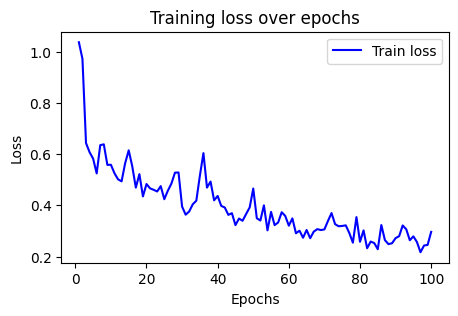

In [ ]:
loss_values = model1_optimasi.history['loss']
# Membuat grafik
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(loss_values) + 1), loss_values, 'b', label='Train loss')
plt.title('Training loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluasi

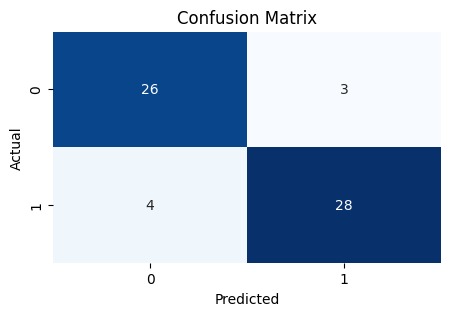

Accuracy : 0.8852459016393442
Precision: 0.9032258064516129
Recall   : 0.875
F1 Score : 0.8888888888888888


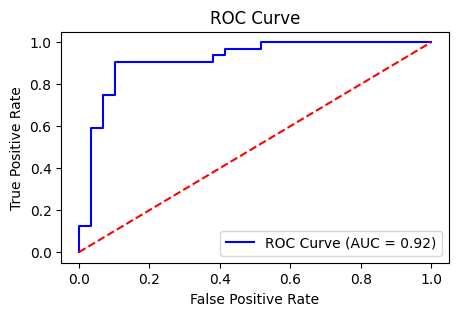

In [ ]:
# Confussion matrix and AUC-ROC

y_pred = model1_optimasi.predict(X_test.values)
y_pred_proba = model1_optimasi.predict_proba(X_test.values)[:, 1]

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Experiment 2

data train and test

In [ ]:
X2 = dataset2.drop('target', axis=1)
y2 = dataset2['target']

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size=0.2, random_state=42)

Implementation SMOTE on dataset

Text(0, 0.5, 'Jumlah')

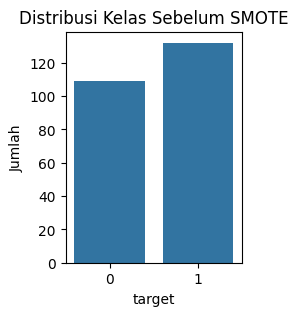

In [ ]:
plt.figure(figsize=(5, 3))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train2)
plt.title('Distribusi Kelas Sebelum SMOTE')
plt.xlabel('target')
plt.ylabel('Jumlah')

In [ ]:
smote = SMOTE(random_state=42)
X_train2_smote, y_train2_smote = smote.fit_resample(X_train2, y_train2)

Text(0, 0.5, 'Jumlah')

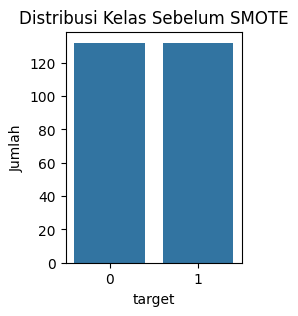

In [ ]:
plt.figure(figsize=(5, 3))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train2_smote)
plt.title('Distribusi Kelas Sebelum SMOTE')
plt.xlabel('target')
plt.ylabel('Jumlah')

train model

In [ ]:
#define model
model2 = TabNetClassifier()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
#train model
model2.fit(
    X_train2_smote.values, y_train2_smote,
    batch_size=32,
    virtual_batch_size=32,
    patience=20
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.78803 |  0:00:00s
epoch 1  | loss: 0.64678 |  0:00:01s
epoch 2  | loss: 0.57156 |  0:00:01s
epoch 3  | loss: 0.5351  |  0:00:02s
epoch 4  | loss: 0.53596 |  0:00:02s
epoch 5  | loss: 0.46537 |  0:00:03s
epoch 6  | loss: 0.47594 |  0:00:03s
epoch 7  | loss: 0.49526 |  0:00:03s
epoch 8  | loss: 0.41615 |  0:00:03s
epoch 9  | loss: 0.42756 |  0:00:04s
epoch 10 | loss: 0.40002 |  0:00:04s
epoch 11 | loss: 0.38889 |  0:00:04s
epoch 12 | loss: 0.45615 |  0:00:05s
epoch 13 | loss: 0.48478 |  0:00:05s
epoch 14 | loss: 0.42268 |  0:00:05s
epoch 15 | loss: 0.41047 |  0:00:05s
epoch 16 | loss: 0.34602 |  0:00:06s
epoch 17 | loss: 0.40089 |  0:00:06s
epoch 18 | loss: 0.37107 |  0:00:07s
epoch 19 | loss: 0.37301 |  0:00:07s
epoch 20 | loss: 0.36914 |  0:00:07s
epoch 21 | loss: 0.392   |  0:00:07s
epoch 22 | loss: 0.34368 |  0:00:07s
epoch 23 | loss: 0.35373 |  0:00:07s
epoch 24 | loss: 0.34099 |  0:00:08s
epoch 25 | loss: 0.3586  |  0:00:08s
epoch 26 | loss: 0.3194  |  0:00:08s
e

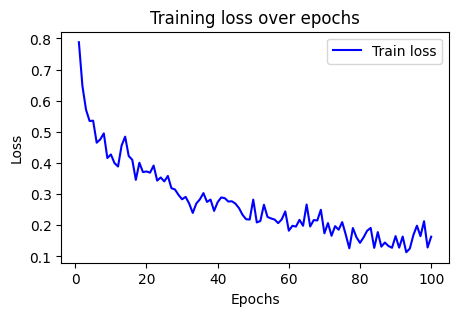

In [ ]:
loss_values = model2.history['loss']

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(loss_values) + 1), loss_values, 'b', label='Train loss')
plt.title('Training loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluasi

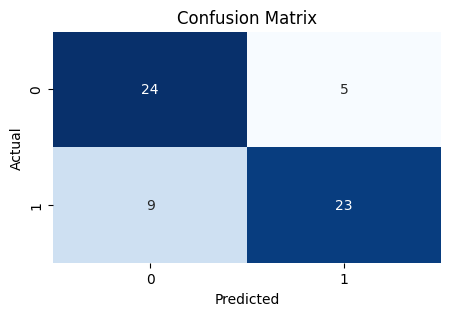

Accuracy : 0.7704918032786885
Precision: 0.8214285714285714
Recall   : 0.71875
F1 Score : 0.7666666666666667


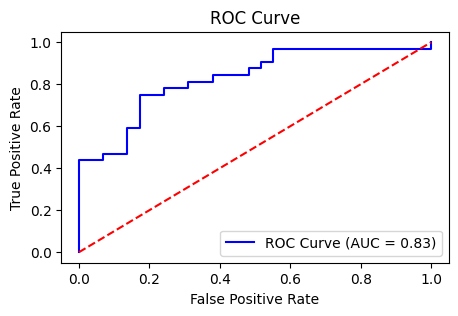

In [ ]:
# Confussion matrix and AUC-ROC

y_pred2 = model2.predict(X_test2.values)
y_pred_proba2 = model2.predict_proba(X_test2.values)[:, 1]

cm = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test2, y_pred2)
precision = precision_score(y_test2, y_pred2, average='binary')
recall = recall_score(y_test2, y_pred2, average='binary')
f1 = f1_score(y_test2, y_pred2, average='binary')

auc = roc_auc_score(y_test2, y_pred_proba2)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

fpr, tpr, thresholds = roc_curve(y_test2, y_pred_proba2)
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Garis diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Implementation Optimization with Optuna

In [ ]:
def objective(trial):
    # define parameters
    n_d = trial.suggest_int('n_d', 8, 32)
    n_a = trial.suggest_int('n_a', 8, 32)
    n_steps = trial.suggest_int('n_steps', 5, 8)
    n_independent = trial.suggest_int('n_independent', 1, 2)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_float('lambda_sparse', 1e-4, 1e-2)
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True)

    # define model with parameters
    model2_optimasi = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        n_independent=n_independent,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_params=dict(lr=learning_rate)
    )

    # train model
    model2_optimasi.fit(
        X_train2_smote.values, y_train2_smote,
        max_epochs=100,
        batch_size=32,
        virtual_batch_size=32,
        patience=20
    )

    # evaluation model
    preds =  model2_optimasi.predict(X_test2.values)
    accuracy = accuracy_score(y_test2, preds)

    return accuracy

# setting optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# best trial
print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-12-18 02:49:33,921] A new study created in memory with name: no-name-c5206f6e-9ccc-49b7-8009-535a915c62f4
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.99247 |  0:00:00s
epoch 1  | loss: 0.62769 |  0:00:00s
epoch 2  | loss: 0.58577 |  0:00:00s
epoch 3  | loss: 0.60672 |  0:00:01s
epoch 4  | loss: 0.60406 |  0:00:01s
epoch 5  | loss: 0.57156 |  0:00:01s
epoch 6  | loss: 0.5468  |  0:00:01s
epoch 7  | loss: 0.44412 |  0:00:02s
epoch 8  | loss: 0.43952 |  0:00:02s
epoch 9  | loss: 0.45524 |  0:00:02s
epoch 10 | loss: 0.39788 |  0:00:03s
epoch 11 | loss: 0.49892 |  0:00:03s
epoch 12 | loss: 0.42789 |  0:00:03s
epoch 13 | loss: 0.39174 |  0:00:03s
epoch 14 | loss: 0.34855 |  0:00:04s
epoch 15 | loss: 0.35675 |  0:00:04s
epoch 16 | loss: 0.40316 |  0:00:04s
epoch 17 | loss: 0.39748 |  0:00:04s
epoch 18 | loss: 0.36314 |  0:00:05s
epoch 19 | loss: 0.36812 |  0:00:05s
epoch 20 | loss: 0.37664 |  0:00:05s
epoch 21 | loss: 0.37828 |  0:00:05s
epoch 22 | loss: 0.3378  |  0:00:06s
epoch 23 | loss: 0.3231  |  0:00:06s
epoch 24 | loss: 0.32488 |  0:00:06s
epoch 25 | loss: 0.37486 |  0:00:06s
epoch 26 | loss: 0.33928 |  0:00:07s
e

[I 2024-12-18 02:50:06,409] Trial 0 finished with value: 0.819672131147541 and parameters: {'n_d': 20, 'n_a': 24, 'n_steps': 6, 'n_independent': 1, 'gamma': 1.1817619204817853, 'lambda_sparse': 0.0021981662374876937, 'learning_rate': 0.012935053140737035}. Best is trial 0 with value: 0.819672131147541.


epoch 99 | loss: 0.219   |  0:00:32s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.21247 |  0:00:00s
epoch 1  | loss: 0.72252 |  0:00:00s
epoch 2  | loss: 0.62562 |  0:00:01s
epoch 3  | loss: 0.54281 |  0:00:01s
epoch 4  | loss: 0.51412 |  0:00:02s
epoch 5  | loss: 0.52921 |  0:00:02s
epoch 6  | loss: 0.50301 |  0:00:02s
epoch 7  | loss: 0.45516 |  0:00:03s
epoch 8  | loss: 0.48098 |  0:00:03s
epoch 9  | loss: 0.3916  |  0:00:04s
epoch 10 | loss: 0.42096 |  0:00:04s
epoch 11 | loss: 0.47024 |  0:00:04s
epoch 12 | loss: 0.4782  |  0:00:05s
epoch 13 | loss: 0.47998 |  0:00:05s
epoch 14 | loss: 0.41035 |  0:00:06s
epoch 15 | loss: 0.36976 |  0:00:06s
epoch 16 | loss: 0.45726 |  0:00:07s
epoch 17 | loss: 0.41214 |  0:00:07s
epoch 18 | loss: 0.36462 |  0:00:08s
epoch 19 | loss: 0.39789 |  0:00:08s
epoch 20 | loss: 0.43046 |  0:00:09s
epoch 21 | loss: 0.42054 |  0:00:10s
epoch 22 | loss: 0.38825 |  0:00:10s
epoch 23 | loss: 0.38586 |  0:00:11s
epoch 24 | loss: 0.35908 |  0:00:11s
epoch 25 | loss: 0.37967 |  0:00:12s
epoch 26 | loss: 0.35952 |  0:00:12s
e

[I 2024-12-18 02:50:51,889] Trial 1 finished with value: 0.8524590163934426 and parameters: {'n_d': 13, 'n_a': 17, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.0401265477059018, 'lambda_sparse': 0.004131973847024052, 'learning_rate': 0.01945551054537731}. Best is trial 1 with value: 0.8524590163934426.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.29396 |  0:00:00s
epoch 1  | loss: 0.76049 |  0:00:00s
epoch 2  | loss: 0.67467 |  0:00:00s
epoch 3  | loss: 0.71435 |  0:00:01s
epoch 4  | loss: 0.6445  |  0:00:01s
epoch 5  | loss: 0.58529 |  0:00:01s
epoch 6  | loss: 0.54571 |  0:00:01s
epoch 7  | loss: 0.47189 |  0:00:02s
epoch 8  | loss: 0.48911 |  0:00:02s
epoch 9  | loss: 0.51616 |  0:00:02s
epoch 10 | loss: 0.51357 |  0:00:02s
epoch 11 | loss: 0.49754 |  0:00:03s
epoch 12 | loss: 0.46853 |  0:00:03s
epoch 13 | loss: 0.47236 |  0:00:03s
epoch 14 | loss: 0.41777 |  0:00:04s
epoch 15 | loss: 0.45907 |  0:00:04s
epoch 16 | loss: 0.44163 |  0:00:04s
epoch 17 | loss: 0.46392 |  0:00:04s
epoch 18 | loss: 0.47084 |  0:00:05s
epoch 19 | loss: 0.41577 |  0:00:05s
epoch 20 | loss: 0.38623 |  0:00:05s
epoch 21 | loss: 0.38051 |  0:00:06s
epoch 22 | loss: 0.38709 |  0:00:06s
epoch 23 | loss: 0.39861 |  0:00:06s
epoch 24 | loss: 0.36679 |  0:00:07s
epoch 25 | loss: 0.34782 |  0:00:07s
epoch 26 | loss: 0.36985 |  0:00:07s
e

[I 2024-12-18 02:51:22,128] Trial 2 finished with value: 0.8032786885245902 and parameters: {'n_d': 25, 'n_a': 16, 'n_steps': 6, 'n_independent': 1, 'gamma': 1.7041089555636857, 'lambda_sparse': 0.00961272186107852, 'learning_rate': 0.04424400017619979}. Best is trial 1 with value: 0.8524590163934426.


epoch 99 | loss: 0.27026 |  0:00:30s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.05103 |  0:00:00s
epoch 1  | loss: 1.04665 |  0:00:00s
epoch 2  | loss: 0.68135 |  0:00:01s
epoch 3  | loss: 0.78777 |  0:00:01s
epoch 4  | loss: 0.58519 |  0:00:01s
epoch 5  | loss: 0.59133 |  0:00:02s
epoch 6  | loss: 0.73435 |  0:00:02s
epoch 7  | loss: 0.50607 |  0:00:02s
epoch 8  | loss: 0.52783 |  0:00:03s
epoch 9  | loss: 0.5277  |  0:00:03s
epoch 10 | loss: 0.48701 |  0:00:03s
epoch 11 | loss: 0.53173 |  0:00:04s
epoch 12 | loss: 0.49049 |  0:00:04s
epoch 13 | loss: 0.49832 |  0:00:05s
epoch 14 | loss: 0.51112 |  0:00:05s
epoch 15 | loss: 0.47055 |  0:00:05s
epoch 16 | loss: 0.4846  |  0:00:06s
epoch 17 | loss: 0.42964 |  0:00:07s
epoch 18 | loss: 0.42261 |  0:00:07s
epoch 19 | loss: 0.43371 |  0:00:08s
epoch 20 | loss: 0.43145 |  0:00:08s
epoch 21 | loss: 0.42585 |  0:00:09s
epoch 22 | loss: 0.41466 |  0:00:09s
epoch 23 | loss: 0.36753 |  0:00:10s
epoch 24 | loss: 0.38653 |  0:00:10s
epoch 25 | loss: 0.47393 |  0:00:11s
epoch 26 | loss: 0.41921 |  0:00:12s
e

[I 2024-12-18 02:52:04,467] Trial 3 finished with value: 0.7540983606557377 and parameters: {'n_d': 17, 'n_a': 26, 'n_steps': 7, 'n_independent': 2, 'gamma': 1.6602284898289077, 'lambda_sparse': 0.00522518408486625, 'learning_rate': 0.04753959157721918}. Best is trial 1 with value: 0.8524590163934426.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.2595  |  0:00:00s
epoch 1  | loss: 1.10682 |  0:00:01s
epoch 2  | loss: 0.70949 |  0:00:01s
epoch 3  | loss: 0.62877 |  0:00:02s
epoch 4  | loss: 0.57438 |  0:00:02s
epoch 5  | loss: 0.62603 |  0:00:02s
epoch 6  | loss: 0.47775 |  0:00:03s
epoch 7  | loss: 0.47472 |  0:00:03s
epoch 8  | loss: 0.52096 |  0:00:03s
epoch 9  | loss: 0.46702 |  0:00:04s
epoch 10 | loss: 0.45084 |  0:00:04s
epoch 11 | loss: 0.43523 |  0:00:05s
epoch 12 | loss: 0.45663 |  0:00:05s
epoch 13 | loss: 0.42243 |  0:00:05s
epoch 14 | loss: 0.38546 |  0:00:06s
epoch 15 | loss: 0.38608 |  0:00:06s
epoch 16 | loss: 0.37245 |  0:00:06s
epoch 17 | loss: 0.39157 |  0:00:07s
epoch 18 | loss: 0.35843 |  0:00:07s
epoch 19 | loss: 0.36818 |  0:00:07s
epoch 20 | loss: 0.33353 |  0:00:08s
epoch 21 | loss: 0.30909 |  0:00:08s
epoch 22 | loss: 0.35659 |  0:00:08s
epoch 23 | loss: 0.37881 |  0:00:09s
epoch 24 | loss: 0.34432 |  0:00:09s
epoch 25 | loss: 0.44203 |  0:00:09s
epoch 26 | loss: 0.36345 |  0:00:10s
e

[I 2024-12-18 02:52:43,203] Trial 4 finished with value: 0.8360655737704918 and parameters: {'n_d': 13, 'n_a': 11, 'n_steps': 7, 'n_independent': 2, 'gamma': 1.819329813204251, 'lambda_sparse': 0.0024485434886166745, 'learning_rate': 0.07766370653214988}. Best is trial 1 with value: 0.8524590163934426.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.08725 |  0:00:00s
epoch 1  | loss: 0.67853 |  0:00:00s
epoch 2  | loss: 0.65422 |  0:00:00s
epoch 3  | loss: 0.57759 |  0:00:00s
epoch 4  | loss: 0.45461 |  0:00:01s
epoch 5  | loss: 0.50385 |  0:00:01s
epoch 6  | loss: 0.43816 |  0:00:01s
epoch 7  | loss: 0.41569 |  0:00:01s
epoch 8  | loss: 0.40314 |  0:00:02s
epoch 9  | loss: 0.4753  |  0:00:02s
epoch 10 | loss: 0.45395 |  0:00:02s
epoch 11 | loss: 0.41184 |  0:00:02s
epoch 12 | loss: 0.41797 |  0:00:02s
epoch 13 | loss: 0.36008 |  0:00:03s
epoch 14 | loss: 0.32527 |  0:00:03s
epoch 15 | loss: 0.30473 |  0:00:03s
epoch 16 | loss: 0.33324 |  0:00:03s
epoch 17 | loss: 0.35632 |  0:00:04s
epoch 18 | loss: 0.30903 |  0:00:04s
epoch 19 | loss: 0.32685 |  0:00:04s
epoch 20 | loss: 0.31348 |  0:00:05s
epoch 21 | loss: 0.30105 |  0:00:05s
epoch 22 | loss: 0.31976 |  0:00:05s
epoch 23 | loss: 0.29477 |  0:00:06s
epoch 24 | loss: 0.3361  |  0:00:06s
epoch 25 | loss: 0.3134  |  0:00:06s
epoch 26 | loss: 0.32711 |  0:00:07s
e

[I 2024-12-18 02:53:09,479] Trial 5 finished with value: 0.8360655737704918 and parameters: {'n_d': 14, 'n_a': 25, 'n_steps': 5, 'n_independent': 1, 'gamma': 1.5423297142558487, 'lambda_sparse': 0.0062647163925139155, 'learning_rate': 0.018741260716536548}. Best is trial 1 with value: 0.8524590163934426.


epoch 99 | loss: 0.15407 |  0:00:26s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.8771  |  0:00:00s
epoch 1  | loss: 1.11933 |  0:00:00s
epoch 2  | loss: 0.65093 |  0:00:00s
epoch 3  | loss: 0.58188 |  0:00:01s
epoch 4  | loss: 0.62273 |  0:00:01s
epoch 5  | loss: 0.51117 |  0:00:01s
epoch 6  | loss: 0.51528 |  0:00:02s
epoch 7  | loss: 0.51191 |  0:00:02s
epoch 8  | loss: 0.54622 |  0:00:02s
epoch 9  | loss: 0.52702 |  0:00:03s
epoch 10 | loss: 0.48841 |  0:00:03s
epoch 11 | loss: 0.51225 |  0:00:03s
epoch 12 | loss: 0.62526 |  0:00:03s
epoch 13 | loss: 0.52286 |  0:00:04s
epoch 14 | loss: 0.48897 |  0:00:04s
epoch 15 | loss: 0.49844 |  0:00:04s
epoch 16 | loss: 0.48787 |  0:00:05s
epoch 17 | loss: 0.45609 |  0:00:05s
epoch 18 | loss: 0.4305  |  0:00:05s
epoch 19 | loss: 0.44837 |  0:00:06s
epoch 20 | loss: 0.45987 |  0:00:06s
epoch 21 | loss: 0.51151 |  0:00:06s
epoch 22 | loss: 0.44636 |  0:00:07s
epoch 23 | loss: 0.40337 |  0:00:07s
epoch 24 | loss: 0.4324  |  0:00:07s
epoch 25 | loss: 0.39262 |  0:00:08s
epoch 26 | loss: 0.46822 |  0:00:08s
e

[I 2024-12-18 02:53:43,016] Trial 6 finished with value: 0.8032786885245902 and parameters: {'n_d': 25, 'n_a': 22, 'n_steps': 7, 'n_independent': 1, 'gamma': 1.700871624691574, 'lambda_sparse': 0.00887786226977557, 'learning_rate': 0.0746490260885557}. Best is trial 1 with value: 0.8524590163934426.


epoch 99 | loss: 0.34464 |  0:00:33s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.18394 |  0:00:00s
epoch 1  | loss: 1.45234 |  0:00:00s
epoch 2  | loss: 0.72191 |  0:00:00s
epoch 3  | loss: 0.67569 |  0:00:01s
epoch 4  | loss: 0.58799 |  0:00:01s
epoch 5  | loss: 0.56672 |  0:00:01s
epoch 6  | loss: 0.56913 |  0:00:01s
epoch 7  | loss: 0.53466 |  0:00:02s
epoch 8  | loss: 0.53878 |  0:00:02s
epoch 9  | loss: 0.57669 |  0:00:02s
epoch 10 | loss: 0.54075 |  0:00:03s
epoch 11 | loss: 0.53302 |  0:00:03s
epoch 12 | loss: 0.46846 |  0:00:03s
epoch 13 | loss: 0.54562 |  0:00:03s
epoch 14 | loss: 0.49139 |  0:00:04s
epoch 15 | loss: 0.52105 |  0:00:04s
epoch 16 | loss: 0.4467  |  0:00:04s
epoch 17 | loss: 0.4882  |  0:00:05s
epoch 18 | loss: 0.44806 |  0:00:05s
epoch 19 | loss: 0.47986 |  0:00:06s
epoch 20 | loss: 0.52106 |  0:00:06s
epoch 21 | loss: 0.47958 |  0:00:06s
epoch 22 | loss: 0.44799 |  0:00:07s
epoch 23 | loss: 0.48768 |  0:00:07s
epoch 24 | loss: 0.50676 |  0:00:07s
epoch 25 | loss: 0.47112 |  0:00:08s
epoch 26 | loss: 0.47897 |  0:00:08s
e

[I 2024-12-18 02:54:13,462] Trial 7 finished with value: 0.8524590163934426 and parameters: {'n_d': 31, 'n_a': 15, 'n_steps': 6, 'n_independent': 1, 'gamma': 1.7449666479611583, 'lambda_sparse': 0.008828915313416832, 'learning_rate': 0.09504763803681654}. Best is trial 1 with value: 0.8524590163934426.


epoch 99 | loss: 0.43745 |  0:00:30s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.07313 |  0:00:00s
epoch 1  | loss: 0.68945 |  0:00:00s
epoch 2  | loss: 0.5087  |  0:00:00s
epoch 3  | loss: 0.57159 |  0:00:01s
epoch 4  | loss: 0.50975 |  0:00:01s
epoch 5  | loss: 0.5542  |  0:00:01s
epoch 6  | loss: 0.49259 |  0:00:01s
epoch 7  | loss: 0.45823 |  0:00:02s
epoch 8  | loss: 0.47402 |  0:00:02s
epoch 9  | loss: 0.43012 |  0:00:02s
epoch 10 | loss: 0.4355  |  0:00:03s
epoch 11 | loss: 0.38323 |  0:00:03s
epoch 12 | loss: 0.42763 |  0:00:03s
epoch 13 | loss: 0.38303 |  0:00:03s
epoch 14 | loss: 0.41932 |  0:00:04s
epoch 15 | loss: 0.39439 |  0:00:04s
epoch 16 | loss: 0.38365 |  0:00:05s
epoch 17 | loss: 0.39283 |  0:00:05s
epoch 18 | loss: 0.41361 |  0:00:05s
epoch 19 | loss: 0.39341 |  0:00:06s
epoch 20 | loss: 0.38014 |  0:00:06s
epoch 21 | loss: 0.37082 |  0:00:06s
epoch 22 | loss: 0.33003 |  0:00:07s
epoch 23 | loss: 0.3309  |  0:00:07s
epoch 24 | loss: 0.35852 |  0:00:08s
epoch 25 | loss: 0.44102 |  0:00:08s
epoch 26 | loss: 0.40275 |  0:00:08s
e

[I 2024-12-18 02:54:44,705] Trial 8 finished with value: 0.819672131147541 and parameters: {'n_d': 16, 'n_a': 25, 'n_steps': 5, 'n_independent': 2, 'gamma': 1.4744488534108307, 'lambda_sparse': 0.0032934213937225424, 'learning_rate': 0.04309238085614518}. Best is trial 1 with value: 0.8524590163934426.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.1182  |  0:00:00s
epoch 1  | loss: 0.90385 |  0:00:00s
epoch 2  | loss: 0.64733 |  0:00:01s
epoch 3  | loss: 0.52004 |  0:00:01s
epoch 4  | loss: 0.5652  |  0:00:01s
epoch 5  | loss: 0.54905 |  0:00:02s
epoch 6  | loss: 0.48191 |  0:00:02s
epoch 7  | loss: 0.42377 |  0:00:03s
epoch 8  | loss: 0.4317  |  0:00:03s
epoch 9  | loss: 0.43358 |  0:00:03s
epoch 10 | loss: 0.41912 |  0:00:04s
epoch 11 | loss: 0.39083 |  0:00:04s
epoch 12 | loss: 0.35442 |  0:00:04s
epoch 13 | loss: 0.47109 |  0:00:05s
epoch 14 | loss: 0.43073 |  0:00:05s
epoch 15 | loss: 0.48632 |  0:00:05s
epoch 16 | loss: 0.44021 |  0:00:06s
epoch 17 | loss: 0.37362 |  0:00:06s
epoch 18 | loss: 0.40015 |  0:00:07s
epoch 19 | loss: 0.397   |  0:00:07s
epoch 20 | loss: 0.3957  |  0:00:07s
epoch 21 | loss: 0.39174 |  0:00:08s
epoch 22 | loss: 0.38084 |  0:00:08s
epoch 23 | loss: 0.36992 |  0:00:08s
epoch 24 | loss: 0.36565 |  0:00:08s
epoch 25 | loss: 0.37031 |  0:00:09s
epoch 26 | loss: 0.33837 |  0:00:09s
e

[I 2024-12-18 02:55:15,612] Trial 9 finished with value: 0.8524590163934426 and parameters: {'n_d': 27, 'n_a': 26, 'n_steps': 6, 'n_independent': 1, 'gamma': 1.1973090469512848, 'lambda_sparse': 0.0020484067284219777, 'learning_rate': 0.029216131894881897}. Best is trial 1 with value: 0.8524590163934426.


epoch 99 | loss: 0.2538  |  0:00:30s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.27733 |  0:00:00s
epoch 1  | loss: 0.76843 |  0:00:00s
epoch 2  | loss: 0.61245 |  0:00:01s
epoch 3  | loss: 0.63186 |  0:00:01s
epoch 4  | loss: 0.48094 |  0:00:01s
epoch 5  | loss: 0.41989 |  0:00:02s
epoch 6  | loss: 0.54473 |  0:00:02s
epoch 7  | loss: 0.52296 |  0:00:03s
epoch 8  | loss: 0.48291 |  0:00:04s
epoch 9  | loss: 0.44932 |  0:00:04s
epoch 10 | loss: 0.503   |  0:00:05s
epoch 11 | loss: 0.45485 |  0:00:05s
epoch 12 | loss: 0.45775 |  0:00:06s
epoch 13 | loss: 0.418   |  0:00:06s
epoch 14 | loss: 0.44819 |  0:00:07s
epoch 15 | loss: 0.4169  |  0:00:07s
epoch 16 | loss: 0.38232 |  0:00:08s
epoch 17 | loss: 0.37439 |  0:00:08s
epoch 18 | loss: 0.37641 |  0:00:08s
epoch 19 | loss: 0.43287 |  0:00:09s
epoch 20 | loss: 0.34308 |  0:00:09s
epoch 21 | loss: 0.48258 |  0:00:09s
epoch 22 | loss: 0.42808 |  0:00:10s
epoch 23 | loss: 0.43151 |  0:00:10s
epoch 24 | loss: 0.38257 |  0:00:10s
epoch 25 | loss: 0.35575 |  0:00:11s
epoch 26 | loss: 0.34694 |  0:00:11s
e

[I 2024-12-18 02:55:58,478] Trial 10 finished with value: 0.9016393442622951 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.0251532561037215, 'lambda_sparse': 0.0002636764949758459, 'learning_rate': 0.021142746612199465}. Best is trial 10 with value: 0.9016393442622951.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.72009 |  0:00:00s
epoch 1  | loss: 0.57737 |  0:00:00s
epoch 2  | loss: 0.61119 |  0:00:01s
epoch 3  | loss: 0.54543 |  0:00:01s
epoch 4  | loss: 0.47075 |  0:00:01s
epoch 5  | loss: 0.46785 |  0:00:02s
epoch 6  | loss: 0.468   |  0:00:02s
epoch 7  | loss: 0.4636  |  0:00:03s
epoch 8  | loss: 0.39569 |  0:00:03s
epoch 9  | loss: 0.37285 |  0:00:03s
epoch 10 | loss: 0.37505 |  0:00:04s
epoch 11 | loss: 0.41249 |  0:00:04s
epoch 12 | loss: 0.36651 |  0:00:05s
epoch 13 | loss: 0.4756  |  0:00:05s
epoch 14 | loss: 0.34402 |  0:00:06s
epoch 15 | loss: 0.30493 |  0:00:06s
epoch 16 | loss: 0.36755 |  0:00:07s
epoch 17 | loss: 0.37713 |  0:00:07s
epoch 18 | loss: 0.37625 |  0:00:08s
epoch 19 | loss: 0.37672 |  0:00:09s
epoch 20 | loss: 0.38603 |  0:00:09s
epoch 21 | loss: 0.3739  |  0:00:10s
epoch 22 | loss: 0.38737 |  0:00:10s
epoch 23 | loss: 0.33617 |  0:00:10s
epoch 24 | loss: 0.3651  |  0:00:11s
epoch 25 | loss: 0.37272 |  0:00:11s
epoch 26 | loss: 0.3758  |  0:00:12s
e

[I 2024-12-18 02:56:42,186] Trial 11 finished with value: 0.8360655737704918 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.011537684875385, 'lambda_sparse': 0.000263500437684366, 'learning_rate': 0.020590237808946976}. Best is trial 10 with value: 0.9016393442622951.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.18685 |  0:00:00s
epoch 1  | loss: 0.92836 |  0:00:00s
epoch 2  | loss: 0.71574 |  0:00:01s
epoch 3  | loss: 0.61345 |  0:00:01s
epoch 4  | loss: 0.59482 |  0:00:01s
epoch 5  | loss: 0.5336  |  0:00:02s
epoch 6  | loss: 0.56138 |  0:00:02s
epoch 7  | loss: 0.45313 |  0:00:02s
epoch 8  | loss: 0.4584  |  0:00:03s
epoch 9  | loss: 0.49768 |  0:00:03s
epoch 10 | loss: 0.46882 |  0:00:04s
epoch 11 | loss: 0.49783 |  0:00:04s
epoch 12 | loss: 0.49118 |  0:00:04s
epoch 13 | loss: 0.47997 |  0:00:05s
epoch 14 | loss: 0.43977 |  0:00:05s
epoch 15 | loss: 0.51309 |  0:00:05s
epoch 16 | loss: 0.47461 |  0:00:06s
epoch 17 | loss: 0.44482 |  0:00:07s
epoch 18 | loss: 0.45187 |  0:00:07s
epoch 19 | loss: 0.41967 |  0:00:08s
epoch 20 | loss: 0.41584 |  0:00:08s
epoch 21 | loss: 0.4055  |  0:00:09s
epoch 22 | loss: 0.37784 |  0:00:09s
epoch 23 | loss: 0.46883 |  0:00:10s
epoch 24 | loss: 0.41501 |  0:00:10s
epoch 25 | loss: 0.4205  |  0:00:11s
epoch 26 | loss: 0.39887 |  0:00:11s
e

[I 2024-12-18 02:57:24,714] Trial 12 finished with value: 0.819672131147541 and parameters: {'n_d': 8, 'n_a': 9, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.0251325166444545, 'lambda_sparse': 0.0001550352516082312, 'learning_rate': 0.011791090850121082}. Best is trial 10 with value: 0.9016393442622951.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.90717 |  0:00:00s
epoch 1  | loss: 0.68317 |  0:00:00s
epoch 2  | loss: 0.59391 |  0:00:01s
epoch 3  | loss: 0.6109  |  0:00:01s
epoch 4  | loss: 0.5524  |  0:00:01s
epoch 5  | loss: 0.56751 |  0:00:02s
epoch 6  | loss: 0.52121 |  0:00:02s
epoch 7  | loss: 0.56493 |  0:00:03s
epoch 8  | loss: 0.48854 |  0:00:03s
epoch 9  | loss: 0.50644 |  0:00:03s
epoch 10 | loss: 0.46888 |  0:00:04s
epoch 11 | loss: 0.4401  |  0:00:04s
epoch 12 | loss: 0.50299 |  0:00:04s
epoch 13 | loss: 0.39587 |  0:00:05s
epoch 14 | loss: 0.5082  |  0:00:05s
epoch 15 | loss: 0.58167 |  0:00:06s
epoch 16 | loss: 0.46865 |  0:00:06s
epoch 17 | loss: 0.44713 |  0:00:06s
epoch 18 | loss: 0.46207 |  0:00:07s
epoch 19 | loss: 0.40986 |  0:00:07s
epoch 20 | loss: 0.4012  |  0:00:08s
epoch 21 | loss: 0.41457 |  0:00:08s
epoch 22 | loss: 0.41986 |  0:00:08s
epoch 23 | loss: 0.42736 |  0:00:09s
epoch 24 | loss: 0.42478 |  0:00:09s
epoch 25 | loss: 0.42573 |  0:00:10s
epoch 26 | loss: 0.3951  |  0:00:10s
e

[I 2024-12-18 02:58:09,838] Trial 13 finished with value: 0.8032786885245902 and parameters: {'n_d': 11, 'n_a': 16, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.2693288391451474, 'lambda_sparse': 0.0069887282053468554, 'learning_rate': 0.021842731354026115}. Best is trial 10 with value: 0.9016393442622951.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.1161  |  0:00:00s
epoch 1  | loss: 0.8887  |  0:00:00s
epoch 2  | loss: 0.72973 |  0:00:01s
epoch 3  | loss: 0.7277  |  0:00:01s
epoch 4  | loss: 0.60697 |  0:00:01s
epoch 5  | loss: 0.60859 |  0:00:02s
epoch 6  | loss: 0.62321 |  0:00:02s
epoch 7  | loss: 0.57628 |  0:00:03s
epoch 8  | loss: 0.53249 |  0:00:03s
epoch 9  | loss: 0.57877 |  0:00:03s
epoch 10 | loss: 0.505   |  0:00:04s
epoch 11 | loss: 0.53215 |  0:00:04s
epoch 12 | loss: 0.46356 |  0:00:05s
epoch 13 | loss: 0.47789 |  0:00:05s
epoch 14 | loss: 0.48399 |  0:00:05s
epoch 15 | loss: 0.56333 |  0:00:06s
epoch 16 | loss: 0.48311 |  0:00:06s
epoch 17 | loss: 0.45283 |  0:00:07s
epoch 18 | loss: 0.45849 |  0:00:07s
epoch 19 | loss: 0.48996 |  0:00:07s
epoch 20 | loss: 0.50883 |  0:00:08s
epoch 21 | loss: 0.47682 |  0:00:08s
epoch 22 | loss: 0.48633 |  0:00:08s
epoch 23 | loss: 0.60143 |  0:00:09s
epoch 24 | loss: 0.50331 |  0:00:10s
epoch 25 | loss: 0.44323 |  0:00:10s
epoch 26 | loss: 0.41193 |  0:00:11s
e

[I 2024-12-18 02:58:52,531] Trial 14 finished with value: 0.8032786885245902 and parameters: {'n_d': 11, 'n_a': 12, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.9871609537217534, 'lambda_sparse': 0.0039262945966207965, 'learning_rate': 0.015256271842190104}. Best is trial 10 with value: 0.9016393442622951.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.35806 |  0:00:00s
epoch 1  | loss: 1.12155 |  0:00:01s
epoch 2  | loss: 0.91785 |  0:00:01s
epoch 3  | loss: 1.08339 |  0:00:01s
epoch 4  | loss: 0.92906 |  0:00:02s
epoch 5  | loss: 0.69918 |  0:00:02s
epoch 6  | loss: 0.59773 |  0:00:03s
epoch 7  | loss: 0.57166 |  0:00:03s
epoch 8  | loss: 0.50096 |  0:00:03s
epoch 9  | loss: 0.57576 |  0:00:04s
epoch 10 | loss: 0.50122 |  0:00:04s
epoch 11 | loss: 0.59439 |  0:00:05s
epoch 12 | loss: 0.51891 |  0:00:05s
epoch 13 | loss: 0.4988  |  0:00:05s
epoch 14 | loss: 0.53208 |  0:00:06s
epoch 15 | loss: 0.46446 |  0:00:06s
epoch 16 | loss: 0.45054 |  0:00:06s
epoch 17 | loss: 0.47518 |  0:00:07s
epoch 18 | loss: 0.4574  |  0:00:07s
epoch 19 | loss: 0.43798 |  0:00:08s
epoch 20 | loss: 0.44368 |  0:00:08s
epoch 21 | loss: 0.43563 |  0:00:08s
epoch 22 | loss: 0.50451 |  0:00:09s
epoch 23 | loss: 0.40082 |  0:00:09s
epoch 24 | loss: 0.42018 |  0:00:10s
epoch 25 | loss: 0.48789 |  0:00:10s
epoch 26 | loss: 0.35329 |  0:00:10s
e

[I 2024-12-18 02:59:35,500] Trial 15 finished with value: 0.8360655737704918 and parameters: {'n_d': 18, 'n_a': 19, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.310011721229792, 'lambda_sparse': 0.004700436167554855, 'learning_rate': 0.028129587429635602}. Best is trial 10 with value: 0.9016393442622951.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.94978 |  0:00:00s
epoch 1  | loss: 0.81544 |  0:00:00s
epoch 2  | loss: 0.73696 |  0:00:01s
epoch 3  | loss: 0.65825 |  0:00:01s
epoch 4  | loss: 0.57416 |  0:00:02s
epoch 5  | loss: 0.54959 |  0:00:02s
epoch 6  | loss: 0.52433 |  0:00:03s
epoch 7  | loss: 0.45992 |  0:00:03s
epoch 8  | loss: 0.47334 |  0:00:04s
epoch 9  | loss: 0.44942 |  0:00:04s
epoch 10 | loss: 0.44697 |  0:00:04s
epoch 11 | loss: 0.44126 |  0:00:05s
epoch 12 | loss: 0.51464 |  0:00:05s
epoch 13 | loss: 0.43152 |  0:00:05s
epoch 14 | loss: 0.46915 |  0:00:06s
epoch 15 | loss: 0.43789 |  0:00:06s
epoch 16 | loss: 0.45437 |  0:00:06s
epoch 17 | loss: 0.46808 |  0:00:07s
epoch 18 | loss: 0.48759 |  0:00:07s
epoch 19 | loss: 0.45455 |  0:00:07s
epoch 20 | loss: 0.45206 |  0:00:08s
epoch 21 | loss: 0.50784 |  0:00:08s
epoch 22 | loss: 0.39599 |  0:00:08s
epoch 23 | loss: 0.42774 |  0:00:09s
epoch 24 | loss: 0.38947 |  0:00:09s
epoch 25 | loss: 0.42509 |  0:00:09s
epoch 26 | loss: 0.3884  |  0:00:10s
e

[I 2024-12-18 03:00:14,856] Trial 16 finished with value: 0.819672131147541 and parameters: {'n_d': 11, 'n_a': 8, 'n_steps': 7, 'n_independent': 2, 'gamma': 1.1101838894233338, 'lambda_sparse': 0.0011777035112612239, 'learning_rate': 0.010262657069929727}. Best is trial 10 with value: 0.9016393442622951.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.26749 |  0:00:00s
epoch 1  | loss: 1.30351 |  0:00:00s
epoch 2  | loss: 0.79046 |  0:00:01s
epoch 3  | loss: 0.78333 |  0:00:01s
epoch 4  | loss: 0.77018 |  0:00:01s
epoch 5  | loss: 0.59003 |  0:00:02s
epoch 6  | loss: 0.58745 |  0:00:02s
epoch 7  | loss: 0.59986 |  0:00:03s
epoch 8  | loss: 0.54185 |  0:00:03s
epoch 9  | loss: 0.55442 |  0:00:03s
epoch 10 | loss: 0.48034 |  0:00:04s
epoch 11 | loss: 0.49541 |  0:00:04s
epoch 12 | loss: 0.54998 |  0:00:05s
epoch 13 | loss: 0.45    |  0:00:06s
epoch 14 | loss: 0.51887 |  0:00:06s
epoch 15 | loss: 0.48967 |  0:00:07s
epoch 16 | loss: 0.5248  |  0:00:07s
epoch 17 | loss: 0.50716 |  0:00:08s
epoch 18 | loss: 0.54301 |  0:00:08s
epoch 19 | loss: 0.50575 |  0:00:09s
epoch 20 | loss: 0.50922 |  0:00:09s
epoch 21 | loss: 0.4576  |  0:00:10s
epoch 22 | loss: 0.47504 |  0:00:10s
epoch 23 | loss: 0.52554 |  0:00:10s
epoch 24 | loss: 0.49862 |  0:00:11s
epoch 25 | loss: 0.46059 |  0:00:11s
epoch 26 | loss: 0.44292 |  0:00:12s
e

[I 2024-12-18 03:00:58,887] Trial 17 finished with value: 0.819672131147541 and parameters: {'n_d': 14, 'n_a': 13, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.377913855166942, 'lambda_sparse': 0.007274379539782299, 'learning_rate': 0.016489260164338236}. Best is trial 10 with value: 0.9016393442622951.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.82354 |  0:00:00s
epoch 1  | loss: 0.67841 |  0:00:00s
epoch 2  | loss: 0.61997 |  0:00:01s
epoch 3  | loss: 0.53288 |  0:00:01s
epoch 4  | loss: 0.49904 |  0:00:01s
epoch 5  | loss: 0.55067 |  0:00:02s
epoch 6  | loss: 0.4678  |  0:00:02s
epoch 7  | loss: 0.46595 |  0:00:02s
epoch 8  | loss: 0.36375 |  0:00:03s
epoch 9  | loss: 0.3866  |  0:00:03s
epoch 10 | loss: 0.38706 |  0:00:03s
epoch 11 | loss: 0.38234 |  0:00:04s
epoch 12 | loss: 0.40727 |  0:00:04s
epoch 13 | loss: 0.39562 |  0:00:05s
epoch 14 | loss: 0.42759 |  0:00:05s
epoch 15 | loss: 0.48823 |  0:00:06s
epoch 16 | loss: 0.40031 |  0:00:06s
epoch 17 | loss: 0.38315 |  0:00:07s
epoch 18 | loss: 0.43414 |  0:00:07s
epoch 19 | loss: 0.42124 |  0:00:08s
epoch 20 | loss: 0.42115 |  0:00:08s
epoch 21 | loss: 0.41135 |  0:00:09s
epoch 22 | loss: 0.43653 |  0:00:09s
epoch 23 | loss: 0.40007 |  0:00:10s
epoch 24 | loss: 0.39958 |  0:00:10s
epoch 25 | loss: 0.39068 |  0:00:11s
epoch 26 | loss: 0.45208 |  0:00:11s
e

[I 2024-12-18 03:01:41,636] Trial 18 finished with value: 0.8360655737704918 and parameters: {'n_d': 8, 'n_a': 19, 'n_steps': 7, 'n_independent': 2, 'gamma': 1.1144276394980637, 'lambda_sparse': 0.0034452775991376094, 'learning_rate': 0.024371445869443818}. Best is trial 10 with value: 0.9016393442622951.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.00599 |  0:00:00s
epoch 1  | loss: 0.9304  |  0:00:00s
epoch 2  | loss: 0.80027 |  0:00:01s
epoch 3  | loss: 0.54603 |  0:00:01s
epoch 4  | loss: 0.54171 |  0:00:02s
epoch 5  | loss: 0.47703 |  0:00:02s
epoch 6  | loss: 0.56254 |  0:00:02s
epoch 7  | loss: 0.44725 |  0:00:03s
epoch 8  | loss: 0.38848 |  0:00:03s
epoch 9  | loss: 0.42586 |  0:00:04s
epoch 10 | loss: 0.50632 |  0:00:04s
epoch 11 | loss: 0.37463 |  0:00:04s
epoch 12 | loss: 0.4349  |  0:00:05s
epoch 13 | loss: 0.40285 |  0:00:05s
epoch 14 | loss: 0.43412 |  0:00:06s
epoch 15 | loss: 0.35627 |  0:00:06s
epoch 16 | loss: 0.37759 |  0:00:06s
epoch 17 | loss: 0.36809 |  0:00:07s
epoch 18 | loss: 0.39668 |  0:00:07s
epoch 19 | loss: 0.34774 |  0:00:08s
epoch 20 | loss: 0.40196 |  0:00:08s
epoch 21 | loss: 0.45182 |  0:00:08s
epoch 22 | loss: 0.44465 |  0:00:09s
epoch 23 | loss: 0.40323 |  0:00:09s
epoch 24 | loss: 0.39504 |  0:00:10s
epoch 25 | loss: 0.37958 |  0:00:10s
epoch 26 | loss: 0.41786 |  0:00:11s
e

[I 2024-12-18 03:02:27,513] Trial 19 finished with value: 0.8688524590163934 and parameters: {'n_d': 11, 'n_a': 31, 'n_steps': 8, 'n_independent': 2, 'gamma': 1.4175641993250196, 'lambda_sparse': 0.0012075365195241368, 'learning_rate': 0.03607250493297763}. Best is trial 10 with value: 0.9016393442622951.


Best trial:
  Value: 0.9016393442622951
  Params: 
    n_d: 8
    n_a: 8
    n_steps: 8
    n_independent: 2
    gamma: 1.0251532561037215
    lambda_sparse: 0.0002636764949758459
    learning_rate: 0.021142746612199465


train model with optimal parameters

In [ ]:
model2_optimasi = TabNetClassifier(
    n_d= 8,
    n_a= 8,
    n_steps= 8,
    n_independent= 2,
    gamma= 1.0251532561037215,
    lambda_sparse= 0.0002636764949758459,
    optimizer_params=dict(lr=0.021142746612199465)
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
#train model
model2_optimasi.fit(
    X_train2_smote.values, y_train2_smote,
    batch_size=32,
    virtual_batch_size=32,
    patience=20
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.27733 |  0:00:00s
epoch 1  | loss: 0.76843 |  0:00:01s
epoch 2  | loss: 0.61245 |  0:00:01s
epoch 3  | loss: 0.63186 |  0:00:02s
epoch 4  | loss: 0.48094 |  0:00:02s
epoch 5  | loss: 0.41989 |  0:00:03s
epoch 6  | loss: 0.54473 |  0:00:03s
epoch 7  | loss: 0.52296 |  0:00:03s
epoch 8  | loss: 0.48291 |  0:00:04s
epoch 9  | loss: 0.44932 |  0:00:04s
epoch 10 | loss: 0.503   |  0:00:04s
epoch 11 | loss: 0.45485 |  0:00:05s
epoch 12 | loss: 0.45775 |  0:00:05s
epoch 13 | loss: 0.418   |  0:00:05s
epoch 14 | loss: 0.44819 |  0:00:06s
epoch 15 | loss: 0.4169  |  0:00:06s
epoch 16 | loss: 0.38232 |  0:00:07s
epoch 17 | loss: 0.37439 |  0:00:07s
epoch 18 | loss: 0.37641 |  0:00:07s
epoch 19 | loss: 0.43287 |  0:00:08s
epoch 20 | loss: 0.34308 |  0:00:08s
epoch 21 | loss: 0.48258 |  0:00:08s
epoch 22 | loss: 0.42808 |  0:00:09s
epoch 23 | loss: 0.43151 |  0:00:09s
epoch 24 | loss: 0.38257 |  0:00:09s
epoch 25 | loss: 0.35575 |  0:00:10s
epoch 26 | loss: 0.34694 |  0:00:10s
e

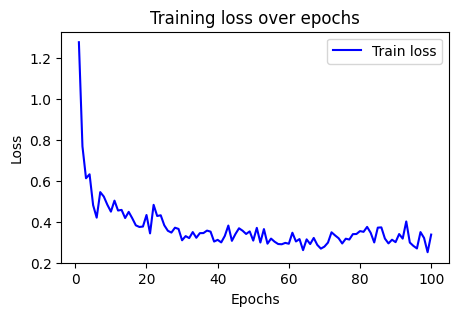

In [ ]:
loss_values = model2_optimasi.history['loss']

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(loss_values) + 1), loss_values, 'b', label='Train loss')
plt.title('Training loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluasi

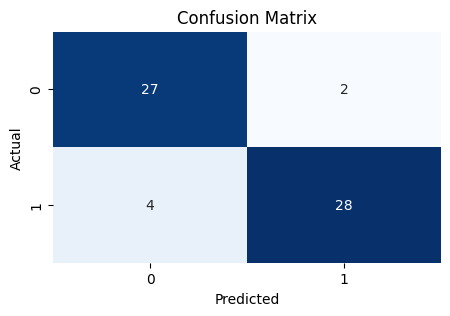

Accuracy : 0.9016393442622951
Precision: 0.9333333333333333
Recall   : 0.875
F1 Score : 0.9032258064516129


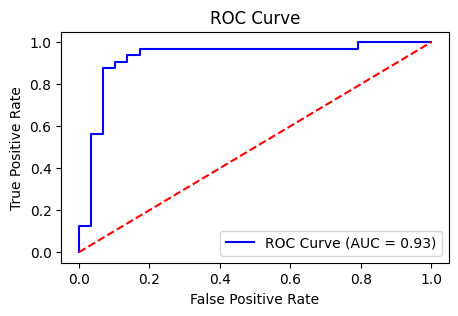

In [ ]:
# Confussion matrix and AUC-ROC

y_pred2 = model2_optimasi.predict(X_test2.values)
y_pred_proba2 = model2_optimasi.predict_proba(X_test2.values)[:, 1]

cm = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test2, y_pred2)
precision = precision_score(y_test2, y_pred2, average='binary')  # Gunakan 'binary' jika binary classification
recall = recall_score(y_test2, y_pred2, average='binary')
f1 = f1_score(y_test2, y_pred2, average='binary')

auc = roc_auc_score(y_test2, y_pred_proba2)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

fpr, tpr, thresholds = roc_curve(y_test2, y_pred_proba2)
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()